In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import random
import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import math
import logging
from functools import partial
from collections import OrderedDict
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "drive/MyDrive/data/Gait/WYH"

all_WHJ_checked.npy		 WYH_FeaVec5_data2.npy
row_EMG.npy			 WYH_FeaVec5_data3.npy
row_segment_emg_all_filterd.npy  WYH_FeaVec5_data4.npy
row_segment_emg_all.npy		 WYH_FeaVec5_data.npy
row_segment_index_all.csv	 WYH_index.csv
WYH_FeaVec5_data1.npy


In [ ]:
dat1 = np.load('drive/MyDrive/XXX.npy')
print(dat1.shape)
print(dat1[0])
# dat = dat1
# dat1 = dat1.reshape(1763, 8, -1)

# print(inputdata.shape)

(1763, 8, 5)
[[ 1.04411312 -1.17415945  1.32861214 -6.06607975  0.02559628]
 [ 4.95858365 -0.45608091  6.71867883 -4.50812744  0.06270344]
 [10.366269   -0.11983166 13.23142343 -3.77069041  0.09159223]
 [ 7.57238002 -0.28024137  9.32601962 -4.08474016  0.07681816]
 [ 4.65468213 -0.5028375   5.77064766 -4.57137396  0.05879871]
 [ 8.1293494  -0.19199047 10.90492816 -4.01376669  0.0888746 ]
 [ 9.80235694 -0.12831942 12.38170192 -3.82662472  0.09743091]
 [ 6.94760146 -0.23168942  8.79234097 -4.1708511   0.07538692]]


In [ ]:
index = pd.read_csv('drive/MyDrive/XXX.csv', header=None)
print(index.shape)
label = index.iloc[:, 0].tolist()
print(label)
print(pd.Series(label).value_counts())
print(len(label))

(1763, 1)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3,

In [ ]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data,label ,transform = None):
        self.transform = transform
        self.data = data
        self.label = label
        self.datanum = len(data)
    def __len__(self):
        return self.datanum
    def __getitem__(self, idx):        
        out_data = torch.tensor(self.data[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label

In [ ]:
train, test, train_label, test_label = train_test_split(dat1, label, test_size=0.1, stratify=label, random_state=0)
print('train data:', len(train))
print('test data:', len(test))

train_data_set = Mydatasets(data=train, label=train_label)
test_data_set = Mydatasets(data=test, label=test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size=16, shuffle=False)

# print('train batches:', len(train_dataloader))
# print('test batches:', len(test_dataloader))

train data: 1586
test data: 177


In [ ]:
##Transformer model, flatted the EMG channel, allows parallel computation the multi-band from multi-channel. 

class PreNorm(nn.Module): 
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout = 0.3):
        super().__init__()
        inner_dim = dim_head *  heads       ##32(4*8)   
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.3

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim, bias = False)   ##better to dim to dim*3

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        h = self.heads        
        v = k = q = self.to_qkv(x)
        
        q = rearrange(q, 'b n (h d) -> b h n d', h=h)
        k = rearrange(k, 'b n (h d) -> b h n d', h=h)
        v = rearrange(v, 'b n (h d) -> b h n d', h=h)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = self.attend(dots)
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):           ##Register the blocks into whole network
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.3):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                #Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
                #Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                #FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class EMG_Model(nn.Module):
    def __init__(self, *, num_classes, dim, depth, patch_dim, heads, mlp_dim, pool = 'cls', dim_head, dropout = 0.0, emb_dropout = 0.):
        super().__init__()
        num_patches = 8      #30*5'
        patch_dim = patch_dim    #1*4'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

#         self.to_patch_embedding = nn.Sequential(
#             #Rearrange('b c f s -> b c (f s)'),
#             nn.Linear(patch_dim, dim),        ##8 to dim
#         )
        self.to_patch_embedding = nn.Linear(patch_dim, dim)  
        

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) ##Generate the pos value'
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))                ##Generate the class value'
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Linear(dim, num_classes)


    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Transmodel = EMG_Model(
    dim = 32, 
    depth = 2,
    patch_dim = 5, 
    heads = 32, 
    mlp_dim = 128, 
    dim_head = 64,
    num_classes = 5).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-3) ##for test of pretrained
#Transmodel.load_state_dict(torch.load('FPGA_state_1'))

cuda:0


In [ ]:
EPOCH = 200
loss_list=[]
los_min=10**10
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    for _, (inputs1, labels) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        # print(inputs1.shape)
        # print(labels.shape)
        inputs1 = inputs1.to(DEVICE)
        labels = labels.to(DEVICE)
        # print(labels)
        # print(inputs1.shape)
        outputs = Transmodel(inputs1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        count=count+1
        running_loss += loss.item()
        
    loss_loss=running_loss/count
    loss_list.append(loss_loss)
    #print('epoch',epoch+1,':finished')
    #print('train_loss:',loss_loss)
    
    with torch.no_grad():
        count=0
        running_loss=0.0
        pre=list()
        lab=list()
        for _, (inputs1, labels) in enumerate(test_dataloader, 0):
            inputs1=inputs1.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = Transmodel(inputs1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            count+=1
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            predicted=predicted.to('cpu')
            labels=labels.to('cpu')
            predicted=predicted.tolist()
            labels=labels.tolist()
            pre.append(predicted)
            lab.append(labels)
        loss_loss=running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        #print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])
#         if los_min>loss_loss:
#             los_min=loss_loss
#             torch.save(Transmodel.state_dict(),'Trans_8lay_state') 


  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score a

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 33}, '1': {'precision': 0.6666666666666666, 'recall': 0.05714285714285714, 'f1-score': 0.10526315789473684, 'support': 35}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 34}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 34}, '4': {'precision': 0.22988505747126436, 'recall': 0.975609756097561, 'f1-score': 0.37209302325581395, 'support': 41}, 'accuracy': 0.23728813559322035, 'macro avg': {'precision': 0.1793103448275862, 'recall': 0.20655052264808363, 'f1-score': 0.09547123623011015, 'support': 177}, 'weighted avg': {'precision': 0.1850769530488993, 'recall': 0.23728813559322035, 'f1-score': 0.10700578802149244, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  1%|          | 2/200 [00:04<06:36,  2.00s/it]

{'0': {'precision': 0.9375, 'recall': 0.45454545454545453, 'f1-score': 0.6122448979591837, 'support': 33}, '1': {'precision': 0.7333333333333333, 'recall': 0.6285714285714286, 'f1-score': 0.6769230769230768, 'support': 35}, '2': {'precision': 0.7647058823529411, 'recall': 0.38235294117647056, 'f1-score': 0.5098039215686274, 'support': 34}, '3': {'precision': 0.4594594594594595, 'recall': 1.0, 'f1-score': 0.6296296296296297, 'support': 34}, '4': {'precision': 0.575, 'recall': 0.5609756097560976, 'f1-score': 0.5679012345679012, 'support': 41}, 'accuracy': 0.6045197740112994, 'macro avg': {'precision': 0.6939997350291469, 'recall': 0.6052890868098902, 'f1-score': 0.5993005521296838, 'support': 177}, 'weighted avg': {'precision': 0.6881400468264876, 'recall': 0.6045197740112994, 'f1-score': 0.5984241846496352, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  2%|▏         | 3/200 [00:05<04:51,  1.48s/it]

{'0': {'precision': 0.5409836065573771, 'recall': 1.0, 'f1-score': 0.7021276595744682, 'support': 33}, '1': {'precision': 0.8181818181818182, 'recall': 0.2571428571428571, 'f1-score': 0.39130434782608686, 'support': 35}, '2': {'precision': 0.8611111111111112, 'recall': 0.9117647058823529, 'f1-score': 0.8857142857142858, 'support': 34}, '3': {'precision': 0.8888888888888888, 'recall': 0.9411764705882353, 'f1-score': 0.9142857142857143, 'support': 34}, '4': {'precision': 0.8181818181818182, 'recall': 0.6585365853658537, 'f1-score': 0.7297297297297297, 'support': 41}, 'accuracy': 0.7457627118644068, 'macro avg': {'precision': 0.7854694485842028, 'recall': 0.7537241237958597, 'f1-score': 0.724632347426057, 'support': 177}, 'weighted avg': {'precision': 0.7883292497074103, 'recall': 0.7457627118644068, 'f1-score': 0.7230778749084148, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  2%|▏         | 4/200 [00:06<04:05,  1.25s/it]

{'0': {'precision': 0.66, 'recall': 1.0, 'f1-score': 0.7951807228915663, 'support': 33}, '1': {'precision': 0.7333333333333333, 'recall': 0.6285714285714286, 'f1-score': 0.6769230769230768, 'support': 35}, '2': {'precision': 0.9090909090909091, 'recall': 0.8823529411764706, 'f1-score': 0.8955223880597014, 'support': 34}, '3': {'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1-score': 0.9411764705882353, 'support': 34}, '4': {'precision': 0.8333333333333334, 'recall': 0.6097560975609756, 'f1-score': 0.7042253521126761, 'support': 41}, 'accuracy': 0.8022598870056498, 'macro avg': {'precision': 0.8153868092691621, 'recall': 0.812371387579422, 'f1-score': 0.8026056021150512, 'support': 177}, 'weighted avg': {'precision': 0.8165108714261256, 'recall': 0.8022598870056498, 'f1-score': 0.7980467354710675, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  2%|▎         | 5/200 [00:07<03:54,  1.20s/it]

{'0': {'precision': 0.8157894736842105, 'recall': 0.9393939393939394, 'f1-score': 0.8732394366197183, 'support': 33}, '1': {'precision': 0.6346153846153846, 'recall': 0.9428571428571428, 'f1-score': 0.7586206896551724, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.36585365853658536, 'f1-score': 0.5357142857142857, 'support': 41}, 'accuracy': 0.8248587570621468, 'macro avg': {'precision': 0.8631459871397953, 'recall': 0.8437385952163572, 'f1-score': 0.8165214183455477, 'support': 177}, 'weighted avg': {'precision': 0.8675347103090191, 'recall': 0.8248587570621468, 'f1-score': 0.8047684879761501, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  3%|▎         | 6/200 [00:08<03:52,  1.20s/it]

{'0': {'precision': 0.7804878048780488, 'recall': 0.9696969696969697, 'f1-score': 0.8648648648648648, 'support': 33}, '1': {'precision': 0.92, 'recall': 0.6571428571428571, 'f1-score': 0.7666666666666667, 'support': 35}, '2': {'precision': 0.967741935483871, 'recall': 0.8823529411764706, 'f1-score': 0.923076923076923, 'support': 34}, '3': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '4': {'precision': 0.8333333333333334, 'recall': 0.8536585365853658, 'f1-score': 0.8433734939759037, 'support': 41}, 'accuracy': 0.8700564971751412, 'macro avg': {'precision': 0.8792599831601032, 'recall': 0.8725702609203326, 'f1-score': 0.8684852786057604, 'support': 177}, 'weighted avg': {'precision': 0.8782318794670783, 'recall': 0.8700564971751412, 'f1-score': 0.8669373650995051, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  4%|▎         | 7/200 [00:09<03:51,  1.20s/it]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9117647058823529, 'f1-score': 0.9538461538461539, 'support': 34}, '4': {'precision': 0.925, 'recall': 0.9024390243902439, 'f1-score': 0.9135802469135802, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9354807473228526, 'recall': 0.9339331830293093, 'f1-score': 0.9333026920862391, 'support': 177}, 'weighted avg': {'precision': 0.9353253768731022, 'recall': 0.9322033898305084, 'f1-score': 0.9324363143082074, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  4%|▍         | 8/200 [00:10<03:33,  1.11s/it]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1-score': 0.9411764705882353, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9327704287456611, 'recall': 0.934927301297459, 'f1-score': 0.9328003813150678, 'support': 177}, 'weighted avg': {'precision': 0.9333376796776072, 'recall': 0.9322033898305084, 'f1-score': 0.9317082061259316, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  4%|▍         | 9/200 [00:11<03:17,  1.03s/it]

{'0': {'precision': 1.0, 'recall': 0.5757575757575758, 'f1-score': 0.7307692307692308, 'support': 33}, '1': {'precision': 0.7368421052631579, 'recall': 0.4, 'f1-score': 0.5185185185185185, 'support': 35}, '2': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.59375, 'recall': 0.926829268292683, 'f1-score': 0.7238095238095238, 'support': 41}, 'accuracy': 0.7853107344632768, 'macro avg': {'precision': 0.8293662843004949, 'recall': 0.7805173688100517, 'f1-score': 0.7752065387681827, 'support': 177}, 'weighted avg': {'precision': 0.8185613583974422, 'recall': 0.7853107344632768, 'f1-score': 0.7719747318926949, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  5%|▌         | 10/200 [00:12<03:07,  1.01it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 0.8888888888888888, 'recall': 0.9142857142857143, 'f1-score': 0.9014084507042254, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9722222222222222, 'recall': 0.8536585365853658, 'f1-score': 0.9090909090909091, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9438001867413632, 'recall': 0.9477064972330396, 'f1-score': 0.9446208803623882, 'support': 177}, 'weighted avg': {'precision': 0.944619316653215, 'recall': 0.943502824858757, 'f1-score': 0.9428248940149857, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  6%|▌         | 11/200 [00:13<02:59,  1.05it/s]

{'0': {'precision': 0.7857142857142857, 'recall': 1.0, 'f1-score': 0.88, 'support': 33}, '1': {'precision': 0.9545454545454546, 'recall': 0.6, 'f1-score': 0.7368421052631579, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 0.9166666666666666, 'recall': 0.9705882352941176, 'f1-score': 0.9428571428571428, 'support': 34}, '4': {'precision': 0.7948717948717948, 'recall': 0.7560975609756098, 'f1-score': 0.7749999999999999, 'support': 41}, 'accuracy': 0.8587570621468926, 'macro avg': {'precision': 0.869307008780693, 'recall': 0.8653371592539456, 'f1-score': 0.8558287385129489, 'support': 177}, 'weighted avg': {'precision': 0.8673170916703477, 'recall': 0.8587570621468926, 'f1-score': 0.8518233200704208, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  6%|▌         | 12/200 [00:14<02:54,  1.08it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.6, 'f1-score': 0.7499999999999999, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '4': {'precision': 0.7551020408163265, 'recall': 0.9024390243902439, 'f1-score': 0.8222222222222222, 'support': 41}, 'accuracy': 0.8926553672316384, 'macro avg': {'precision': 0.9126568522145699, 'recall': 0.8946054519368725, 'f1-score': 0.8915686274509802, 'support': 177}, 'weighted avg': {'precision': 0.9067487119736387, 'recall': 0.8926553672316384, 'f1-score': 0.8875798530334922, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  6%|▋         | 13/200 [00:15<02:49,  1.10it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.8378378378378378, 'recall': 0.8857142857142857, 'f1-score': 0.8611111111111112, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.7317073170731707, 'f1-score': 0.8450704225352113, 'support': 41}, 'accuracy': 0.9152542372881356, 'macro avg': {'precision': 0.9190295558716611, 'recall': 0.9234843205574913, 'f1-score': 0.9157232282584395, 'support': 177}, 'weighted avg': {'precision': 0.9220589903016309, 'recall': 0.9152542372881356, 'f1-score': 0.9125422339435231, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  7%|▋         | 14/200 [00:15<02:47,  1.11it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '4': {'precision': 0.9705882352941176, 'recall': 0.8048780487804879, 'f1-score': 0.8800000000000001, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9330865319100614, 'recall': 0.937950399672064, 'f1-score': 0.9329323185489751, 'support': 177}, 'weighted avg': {'precision': 0.9348480940704269, 'recall': 0.9322033898305084, 'f1-score': 0.9307523911997326, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  8%|▊         | 15/200 [00:16<02:44,  1.13it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9117647058823529, 'f1-score': 0.9538461538461539, 'support': 34}, '4': {'precision': 0.8837209302325582, 'recall': 0.926829268292683, 'f1-score': 0.9047619047619047, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9417471569318355, 'recall': 0.9388010459172582, 'f1-score': 0.9394050433031996, 'support': 177}, 'weighted avg': {'precision': 0.9394422636092974, 'recall': 0.9378531073446328, 'f1-score': 0.9377894436167377, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  8%|▊         | 16/200 [00:17<02:41,  1.14it/s]

{'0': {'precision': 0.9696969696969697, 'recall': 0.9696969696969697, 'f1-score': 0.9696969696969697, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9117647058823529, 'f1-score': 0.9538461538461539, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9466378066378066, 'recall': 0.9445153316315439, 'f1-score': 0.9449840119719639, 'support': 177}, 'weighted avg': {'precision': 0.9446686395838939, 'recall': 0.943502824858757, 'f1-score': 0.9435113521697144, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  8%|▊         | 17/200 [00:18<02:40,  1.14it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.8918918918918919, 'recall': 0.9428571428571428, 'f1-score': 0.9166666666666667, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.9705882352941176, 'recall': 0.8048780487804879, 'f1-score': 0.8800000000000001, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9344155300811648, 'recall': 0.9377823324451733, 'f1-score': 0.9334841204087269, 'support': 177}, 'weighted avg': {'precision': 0.9359786926560291, 'recall': 0.9322033898305084, 'f1-score': 0.9312959868438504, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  9%|▉         | 18/200 [00:19<02:38,  1.15it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.7142857142857143, 'f1-score': 0.8333333333333333, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.8260869565217391, 'recall': 0.926829268292683, 'f1-score': 0.8735632183908046, 'support': 41}, 'accuracy': 0.9152542372881356, 'macro avg': {'precision': 0.9264240525110091, 'recall': 0.9164582906333265, 'f1-score': 0.9152812293213735, 'support': 177}, 'weighted avg': {'precision': 0.9230666990431176, 'recall': 0.9152542372881356, 'f1-score': 0.9130125858974311, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 10%|▉         | 19/200 [00:20<02:44,  1.10it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9523809523809523, 'recall': 0.975609756097561, 'f1-score': 0.963855421686747, 'support': 41}, 'accuracy': 0.9717514124293786, 'macro avg': {'precision': 0.9733333333333333, 'recall': 0.9722648083623693, 'f1-score': 0.9718689685503232, 'support': 177}, 'weighted avg': {'precision': 0.9728275490987355, 'recall': 0.9717514124293786, 'f1-score': 0.9713758096579773, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 10%|█         | 20/200 [00:21<02:57,  1.02it/s]

{'0': {'precision': 0.9393939393939394, 'recall': 0.9393939393939394, 'f1-score': 0.9393939393939394, 'support': 33}, '1': {'precision': 0.85, 'recall': 0.9714285714285714, 'f1-score': 0.9066666666666667, 'support': 35}, '2': {'precision': 0.9393939393939394, 'recall': 0.9117647058823529, 'f1-score': 0.9253731343283583, 'support': 34}, '3': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '4': {'precision': 0.9444444444444444, 'recall': 0.8292682926829268, 'f1-score': 0.883116883116883, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9232178932178933, 'recall': 0.9244887489363818, 'f1-score': 0.9222144725272564, 'support': 177}, 'weighted avg': {'precision': 0.9235523108404464, 'recall': 0.9209039548022598, 'f1-score': 0.9204833403317768, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 10%|█         | 21/200 [00:22<03:07,  1.05s/it]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.94531125608138, 'recall': 0.9468702602992417, 'f1-score': 0.9444876971702623, 'support': 177}, 'weighted avg': {'precision': 0.9459594430992737, 'recall': 0.943502824858757, 'f1-score': 0.9431550905306625, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 11%|█         | 22/200 [00:23<03:04,  1.04s/it]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9069767441860465, 'recall': 0.9512195121951219, 'f1-score': 0.9285714285714286, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9529537903956509, 'recall': 0.9499077679852428, 'f1-score': 0.9497802435505227, 'support': 177}, 'weighted avg': {'precision': 0.9516062989259679, 'recall': 0.9491525423728814, 'f1-score': 0.94875252309342, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 12%|█▏        | 23/200 [00:24<02:54,  1.01it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 0.9666666666666667, 'recall': 0.8285714285714286, 'f1-score': 0.8923076923076922, 'support': 35}, '2': {'precision': 0.96875, 'recall': 0.9117647058823529, 'f1-score': 0.9393939393939394, 'support': 34}, '3': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '4': {'precision': 0.8780487804878049, 'recall': 0.8780487804878049, 'f1-score': 0.8780487804878049, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9248552515930564, 'recall': 0.9236769829883172, 'f1-score': 0.9220708067839638, 'support': 177}, 'weighted avg': {'precision': 0.9234266045706723, 'recall': 0.9209039548022598, 'f1-score': 0.9200442325770567, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 12%|█▏        | 24/200 [00:25<02:47,  1.05it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.9142857142857143, 'f1-score': 0.955223880597015, 'support': 35}, '2': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9555304928989139, 'recall': 0.9574625947940152, 'f1-score': 0.95528095820919, 'support': 177}, 'weighted avg': {'precision': 0.9567192463267397, 'recall': 0.9548022598870056, 'f1-score': 0.9545391359454538, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 12%|█▎        | 25/200 [00:26<02:52,  1.02it/s]

{'0': {'precision': 0.967741935483871, 'recall': 0.9090909090909091, 'f1-score': 0.9374999999999999, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9401861937345808, 'recall': 0.9382764724515082, 'f1-score': 0.9388201633827421, 'support': 177}, 'weighted avg': {'precision': 0.9384832206045984, 'recall': 0.9378531073446328, 'f1-score': 0.9377731753873939, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 13%|█▎        | 26/200 [00:27<02:57,  1.02s/it]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9608928571428571, 'recall': 0.9625087108013938, 'f1-score': 0.9610494934628742, 'support': 177}, 'weighted avg': {'precision': 0.9606083535108959, 'recall': 0.96045197740113, 'f1-score': 0.9598932204649195, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 14%|█▎        | 27/200 [00:28<03:02,  1.05s/it]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '4': {'precision': 0.8780487804878049, 'recall': 0.8780487804878049, 'f1-score': 0.8780487804878049, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9320081049107705, 'recall': 0.9297274031563845, 'f1-score': 0.9276984176491382, 'support': 177}, 'weighted avg': {'precision': 0.930344930121915, 'recall': 0.9265536723163842, 'f1-score': 0.9253527661781162, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 14%|█▍        | 28/200 [00:29<02:50,  1.01it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9609686923549908, 'recall': 0.9615044066407051, 'f1-score': 0.9606552726977053, 'support': 177}, 'weighted avg': {'precision': 0.9607294188861986, 'recall': 0.96045197740113, 'f1-score': 0.9600266544802825, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 14%|█▍        | 29/200 [00:30<02:42,  1.05it/s]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9551598972922501, 'recall': 0.9561017843944674, 'f1-score': 0.9553179616947732, 'support': 177}, 'weighted avg': {'precision': 0.9548000509054846, 'recall': 0.9548022598870056, 'f1-score': 0.9544951683656342, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 15%|█▌        | 30/200 [00:31<02:35,  1.09it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.7142857142857143, 'f1-score': 0.8333333333333333, 'support': 35}, '2': {'precision': 0.96875, 'recall': 0.9117647058823529, 'f1-score': 0.9393939393939394, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.7959183673469388, 'recall': 0.9512195121951219, 'f1-score': 0.8666666666666666, 'support': 41}, 'accuracy': 0.9152542372881356, 'macro avg': {'precision': 0.9303939909297053, 'recall': 0.9154539864726378, 'f1-score': 0.9162821492233256, 'support': 177}, 'weighted avg': {'precision': 0.9253985869300638, 'recall': 0.9152542372881356, 'f1-score': 0.9135445035744139, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 16%|█▌        | 31/200 [00:32<02:31,  1.12it/s]

{'0': {'precision': 0.9696969696969697, 'recall': 0.9696969696969697, 'f1-score': 0.9696969696969697, 'support': 33}, '1': {'precision': 0.9705882352941176, 'recall': 0.9428571428571428, 'f1-score': 0.9565217391304348, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9558588985833568, 'recall': 0.9571162744476949, 'f1-score': 0.955592049865092, 'support': 177}, 'weighted avg': {'precision': 0.9565688898217628, 'recall': 0.9548022598870056, 'f1-score': 0.9547708207447207, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 16%|█▌        | 32/200 [00:32<02:28,  1.13it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9628571428571429, 'recall': 0.9616724738675959, 'f1-score': 0.9608877374538484, 'support': 177}, 'weighted avg': {'precision': 0.9618240516545601, 'recall': 0.96045197740113, 'f1-score': 0.9597837136042321, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 16%|█▋        | 33/200 [00:34<02:37,  1.06it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9354838709677419, 'recall': 0.8285714285714286, 'f1-score': 0.8787878787878788, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9390131505001686, 'recall': 0.9401414845317285, 'f1-score': 0.9386835733039962, 'support': 177}, 'weighted avg': {'precision': 0.9376864797313128, 'recall': 0.9378531073446328, 'f1-score': 0.9368976951446932, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 17%|█▋        | 34/200 [00:35<02:50,  1.03s/it]

{'0': {'precision': 0.8461538461538461, 'recall': 1.0, 'f1-score': 0.9166666666666666, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.9142857142857143, 'f1-score': 0.955223880597015, 'support': 35}, '2': {'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1-score': 0.9411764705882353, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.946320552512503, 'recall': 0.9456978889116622, 'f1-score': 0.9440728227811057, 'support': 177}, 'weighted avg': {'precision': 0.9482719183878863, 'recall': 0.943502824858757, 'f1-score': 0.9439994300114958, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 18%|█▊        | 35/200 [00:36<02:59,  1.09s/it]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9375, 'recall': 0.8571428571428571, 'f1-score': 0.8955223880597014, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '4': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9340930172332611, 'recall': 0.9339128112442318, 'f1-score': 0.9332151568599547, 'support': 177}, 'weighted avg': {'precision': 0.9326646107366446, 'recall': 0.9322033898305084, 'f1-score': 0.9316685088764833, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 18%|█▊        | 36/200 [00:37<02:51,  1.05s/it]

{'0': {'precision': 0.967741935483871, 'recall': 0.9090909090909091, 'f1-score': 0.9374999999999999, 'support': 33}, '1': {'precision': 0.88, 'recall': 0.6285714285714286, 'f1-score': 0.7333333333333334, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.7647058823529411, 'recall': 0.9512195121951219, 'f1-score': 0.8478260869565216, 'support': 41}, 'accuracy': 0.8983050847457628, 'macro avg': {'precision': 0.911060992138791, 'recall': 0.897776369971492, 'f1-score': 0.8979347826086956, 'support': 177}, 'weighted avg': {'precision': 0.9047772197998936, 'recall': 0.8983050847457628, 'f1-score': 0.8947995987881764, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 18%|█▊        | 37/200 [00:38<02:41,  1.01it/s]

{'0': {'precision': 0.9705882352941176, 'recall': 1.0, 'f1-score': 0.9850746268656716, 'support': 33}, '1': {'precision': 0.967741935483871, 'recall': 0.8571428571428571, 'f1-score': 0.909090909090909, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '4': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9456141564939641, 'recall': 0.9460340233654438, 'f1-score': 0.9449109741811661, 'support': 177}, 'weighted avg': {'precision': 0.9438905846039285, 'recall': 0.943502824858757, 'f1-score': 0.9428020060099163, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 19%|█▉        | 38/200 [00:39<02:33,  1.06it/s]

{'0': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1-score': 0.9090909090909091, 'support': 33}, '1': {'precision': 0.8918918918918919, 'recall': 0.9428571428571428, 'f1-score': 0.9166666666666667, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9433625833625834, 'recall': 0.9459993664871714, 'f1-score': 0.9439697983176243, 'support': 177}, 'weighted avg': {'precision': 0.9444364461313612, 'recall': 0.943502824858757, 'f1-score': 0.9431863273057083, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 20%|█▉        | 39/200 [00:40<02:28,  1.08it/s]

{'0': {'precision': 0.9393939393939394, 'recall': 0.9393939393939394, 'f1-score': 0.9393939393939394, 'support': 33}, '1': {'precision': 0.9310344827586207, 'recall': 0.7714285714285715, 'f1-score': 0.8437500000000001, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.8636363636363636, 'recall': 0.926829268292683, 'f1-score': 0.8941176470588236, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.924714388000392, 'recall': 0.9216480028818623, 'f1-score': 0.921119260124024, 'support': 177}, 'weighted avg': {'precision': 0.922251644343988, 'recall': 0.9209039548022598, 'f1-score': 0.9195110384808017, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 20%|██        | 40/200 [00:40<02:25,  1.10it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.8205128205128205, 'recall': 0.9142857142857143, 'f1-score': 0.8648648648648648, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.7560975609756098, 'f1-score': 0.8611111111111112, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9320724889145943, 'recall': 0.9340766550522648, 'f1-score': 0.928212137428304, 'support': 177}, 'weighted avg': {'precision': 0.9344882196800127, 'recall': 0.9265536723163842, 'f1-score': 0.9251928166139298, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 20%|██        | 41/200 [00:41<02:20,  1.13it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 35}, '2': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '3': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '4': {'precision': 0.925, 'recall': 0.9024390243902439, 'f1-score': 0.9135802469135802, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9459266409266409, 'recall': 0.9460340233654438, 'f1-score': 0.9443027246576591, 'support': 177}, 'weighted avg': {'precision': 0.9454218746591629, 'recall': 0.943502824858757, 'f1-score': 0.9428192859207903, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 21%|██        | 42/200 [00:42<02:17,  1.15it/s]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9166666666666666, 'recall': 0.9428571428571428, 'f1-score': 0.9295774647887323, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '4': {'precision': 0.9722222222222222, 'recall': 0.8536585365853658, 'f1-score': 0.9090909090909091, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.939046574770259, 'recall': 0.9412995708261132, 'f1-score': 0.9386961422601349, 'support': 177}, 'weighted avg': {'precision': 0.940064349904894, 'recall': 0.9378531073446328, 'f1-score': 0.937388202592101, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 22%|██▏       | 43/200 [00:43<02:15,  1.16it/s]

{'0': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1-score': 0.9090909090909091, 'support': 33}, '1': {'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'f1-score': 0.8571428571428571, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.8809523809523809, 'recall': 0.9024390243902439, 'f1-score': 0.8915662650602411, 'support': 41}, 'accuracy': 0.9152542372881356, 'macro avg': {'precision': 0.9174942704354467, 'recall': 0.9160874993012726, 'f1-score': 0.916722429437028, 'support': 177}, 'weighted avg': {'precision': 0.9157556191454497, 'recall': 0.9152542372881356, 'f1-score': 0.9154340610608384, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 22%|██▏       | 44/200 [00:44<02:13,  1.16it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.6571428571428571, 'f1-score': 0.7931034482758621, 'support': 35}, '2': {'precision': 0.967741935483871, 'recall': 0.8823529411764706, 'f1-score': 0.923076923076923, 'support': 34}, '3': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '4': {'precision': 0.7755102040816326, 'recall': 0.926829268292683, 'f1-score': 0.8444444444444446, 'support': 41}, 'accuracy': 0.8926553672316384, 'macro avg': {'precision': 0.9115808308435037, 'recall': 0.893265013322402, 'f1-score': 0.8925439800812832, 'support': 177}, 'weighted avg': {'precision': 0.9065223476220898, 'recall': 0.8926553672316384, 'f1-score': 0.8896389996492148, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 22%|██▎       | 45/200 [00:45<02:12,  1.17it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.8648648648648649, 'recall': 0.9142857142857143, 'f1-score': 0.888888888888889, 'support': 35}, '2': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.8292682926829268, 'f1-score': 0.9066666666666667, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9352286120707174, 'recall': 0.9369460955113753, 'f1-score': 0.9333458772680789, 'support': 177}, 'weighted avg': {'precision': 0.9377701009279957, 'recall': 0.9322033898305084, 'f1-score': 0.932060888284408, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 23%|██▎       | 46/200 [00:45<02:11,  1.17it/s]

{'0': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.8918918918918919, 'recall': 0.9705882352941176, 'f1-score': 0.9295774647887325, 'support': 34}, '4': {'precision': 0.9230769230769231, 'recall': 0.8780487804878049, 'f1-score': 0.9, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9347397947397947, 'recall': 0.9344027278317093, 'f1-score': 0.9335345405767942, 'support': 177}, 'weighted avg': {'precision': 0.9337942897264931, 'recall': 0.9322033898305084, 'f1-score': 0.9319930884743489, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 24%|██▎       | 47/200 [00:46<02:11,  1.17it/s]

{'0': {'precision': 0.9642857142857143, 'recall': 0.8181818181818182, 'f1-score': 0.8852459016393442, 'support': 33}, '1': {'precision': 0.90625, 'recall': 0.8285714285714286, 'f1-score': 0.8656716417910447, 'support': 35}, '2': {'precision': 0.9375, 'recall': 0.8823529411764706, 'f1-score': 0.9090909090909091, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.7959183673469388, 'recall': 0.9512195121951219, 'f1-score': 0.8666666666666666, 'support': 41}, 'accuracy': 0.8983050847457628, 'macro avg': {'precision': 0.9096797052154196, 'recall': 0.896065140024968, 'f1-score': 0.8996207381233072, 'support': 177}, 'weighted avg': {'precision': 0.9048527838630743, 'recall': 0.8983050847457628, 'f1-score': 0.8982068807219241, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 24%|██▍       | 48/200 [00:48<02:26,  1.04it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.8780487804878049, 'f1-score': 0.9350649350649352, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9503228659885007, 'recall': 0.9525845460135274, 'f1-score': 0.9496548226817308, 'support': 177}, 'weighted avg': {'precision': 0.9526985459661118, 'recall': 0.9491525423728814, 'f1-score': 0.949066289087255, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 24%|██▍       | 49/200 [00:49<02:35,  1.03s/it]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9166666666666666, 'recall': 0.9705882352941176, 'f1-score': 0.9428571428571428, 'support': 34}, '4': {'precision': 0.9444444444444444, 'recall': 0.8292682926829268, 'f1-score': 0.883116883116883, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9267676767676767, 'recall': 0.9310535566776601, 'f1-score': 0.9273407070338017, 'support': 177}, 'weighted avg': {'precision': 0.9277520972436227, 'recall': 0.9265536723163842, 'f1-score': 0.9255026375794506, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 25%|██▌       | 50/200 [00:50<02:38,  1.06s/it]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9705882352941176, 'recall': 0.9428571428571428, 'f1-score': 0.9565217391304348, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9602312719959778, 'recall': 0.9619943232281827, 'f1-score': 0.9607524852900278, 'support': 177}, 'weighted avg': {'precision': 0.96095616285048, 'recall': 0.96045197740113, 'f1-score': 0.9603345782928708, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 26%|██▌       | 51/200 [00:51<02:30,  1.01s/it]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.9142857142857143, 'f1-score': 0.955223880597015, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9411764705882353, 'f1-score': 0.9696969696969697, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9571171171171171, 'recall': 0.9564582906333264, 'f1-score': 0.9554921346471861, 'support': 177}, 'weighted avg': {'precision': 0.9573064590013741, 'recall': 0.9548022598870056, 'f1-score': 0.9548037642150063, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 26%|██▌       | 52/200 [00:52<02:22,  1.04it/s]

{'0': {'precision': 0.9375, 'recall': 0.9090909090909091, 'f1-score': 0.923076923076923, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9327277753206547, 'recall': 0.9344027278317093, 'f1-score': 0.9325943487198304, 'support': 177}, 'weighted avg': {'precision': 0.9333275549291974, 'recall': 0.9322033898305084, 'f1-score': 0.9317810476080299, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 26%|██▋       | 53/200 [00:52<02:16,  1.08it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.8648648648648649, 'recall': 0.9142857142857143, 'f1-score': 0.888888888888889, 'support': 35}, '2': {'precision': 0.9629629629629629, 'recall': 0.7647058823529411, 'f1-score': 0.8524590163934426, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.8571428571428571, 'recall': 0.8780487804878049, 'f1-score': 0.8674698795180722, 'support': 41}, 'accuracy': 0.903954802259887, 'macro avg': {'precision': 0.9087401687401686, 'recall': 0.905347469364686, 'f1-score': 0.9042845653634421, 'support': 177}, 'weighted avg': {'precision': 0.9064203832565414, 'recall': 0.903954802259887, 'f1-score': 0.902533207269561, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 27%|██▋       | 54/200 [00:53<02:12,  1.10it/s]

{'0': {'precision': 0.8648648648648649, 'recall': 0.9696969696969697, 'f1-score': 0.9142857142857143, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9722222222222222, 'recall': 0.8536585365853658, 'f1-score': 0.9090909090909091, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.938677921619098, 'recall': 0.9416458911724336, 'f1-score': 0.9387515638666534, 'support': 177}, 'weighted avg': {'precision': 0.9402837462159496, 'recall': 0.9378531073446328, 'f1-score': 0.937578543621285, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 28%|██▊       | 55/200 [00:54<02:09,  1.12it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9624661246612465, 'recall': 0.9615044066407051, 'f1-score': 0.9607276778027478, 'support': 177}, 'weighted avg': {'precision': 0.9624921531701193, 'recall': 0.96045197740113, 'f1-score': 0.9602548814242738, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 28%|██▊       | 56/200 [00:55<02:07,  1.13it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9705882352941176, 'recall': 0.9428571428571428, 'f1-score': 0.9565217391304348, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9602830605926581, 'recall': 0.9629986273888713, 'f1-score': 0.9610843126463575, 'support': 177}, 'weighted avg': {'precision': 0.9611311429121159, 'recall': 0.96045197740113, 'f1-score': 0.9602070081567199, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 28%|██▊       | 57/200 [00:56<02:04,  1.15it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9714285714285714, 'recall': 0.8292682926829268, 'f1-score': 0.8947368421052632, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9390233158654212, 'recall': 0.9429965156794425, 'f1-score': 0.9386029661163462, 'support': 177}, 'weighted avg': {'precision': 0.9407058564061239, 'recall': 0.9378531073446328, 'f1-score': 0.9367675105966629, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 29%|██▉       | 58/200 [00:57<02:03,  1.15it/s]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9428571428571428, 'recall': 0.9428571428571428, 'f1-score': 0.9428571428571428, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.975609756097561, 'recall': 0.975609756097561, 'f1-score': 0.975609756097561, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9663322686798296, 'recall': 0.9656898147285522, 'f1-score': 0.9657632502190202, 'support': 177}, 'weighted avg': {'precision': 0.9665528876333961, 'recall': 0.9661016949152542, 'f1-score': 0.966090575248177, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 30%|██▉       | 59/200 [00:58<02:01,  1.16it/s]

{'0': {'precision': 0.9393939393939394, 'recall': 0.9393939393939394, 'f1-score': 0.9393939393939394, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.943365543984739, 'recall': 0.9463456868334917, 'f1-score': 0.9442359438396863, 'support': 177}, 'weighted avg': {'precision': 0.9435339206551884, 'recall': 0.943502824858757, 'f1-score': 0.9428700541281346, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 30%|███       | 60/200 [00:58<01:59,  1.17it/s]

{'0': {'precision': 1.0, 'recall': 0.8181818181818182, 'f1-score': 0.9, 'support': 33}, '1': {'precision': 0.868421052631579, 'recall': 0.9428571428571428, 'f1-score': 0.904109589041096, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9431822800243854, 'recall': 0.9365693417056402, 'f1-score': 0.9373379461849171, 'support': 177}, 'weighted avg': {'precision': 0.9418610658574974, 'recall': 0.9378531073446328, 'f1-score': 0.937456913522537, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 30%|███       | 61/200 [00:59<01:59,  1.17it/s]

{'0': {'precision': 1.0, 'recall': 0.9393939393939394, 'f1-score': 0.96875, 'support': 33}, '1': {'precision': 0.9333333333333333, 'recall': 0.8, 'f1-score': 0.8615384615384616, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.8444444444444444, 'recall': 0.926829268292683, 'f1-score': 0.8837209302325582, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9387301587301587, 'recall': 0.9332446415373244, 'f1-score': 0.9341890419152806, 'support': 177}, 'weighted avg': {'precision': 0.9346246973365615, 'recall': 0.9322033898305084, 'f1-score': 0.9315874129873676, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 31%|███       | 62/200 [01:00<02:07,  1.08it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 0.8918918918918919, 'recall': 0.9428571428571428, 'f1-score': 0.9166666666666667, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.8292682926829268, 'f1-score': 0.9066666666666667, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9456456456456456, 'recall': 0.9485427341668375, 'f1-score': 0.9445387348969441, 'support': 177}, 'weighted avg': {'precision': 0.9477952528799987, 'recall': 0.943502824858757, 'f1-score': 0.9428930006946703, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 32%|███▏      | 63/200 [01:02<02:16,  1.00it/s]

{'0': {'precision': 0.9310344827586207, 'recall': 0.8181818181818182, 'f1-score': 0.8709677419354839, 'support': 33}, '1': {'precision': 0.825, 'recall': 0.9428571428571428, 'f1-score': 0.88, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9487179487179487, 'recall': 0.9024390243902439, 'f1-score': 0.9249999999999999, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9352362005810282, 'recall': 0.932695597085841, 'f1-score': 0.932294997662459, 'support': 177}, 'weighted avg': {'precision': 0.9351703121866768, 'recall': 0.9322033898305084, 'f1-score': 0.9320575246366246, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 32%|███▏      | 64/200 [01:03<02:24,  1.06s/it]

{'0': {'precision': 0.9375, 'recall': 0.9090909090909091, 'f1-score': 0.923076923076923, 'support': 33}, '1': {'precision': 0.8918918918918919, 'recall': 0.9428571428571428, 'f1-score': 0.9166666666666667, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9550358875358874, 'recall': 0.955755464048147, 'f1-score': 0.9550501672240802, 'support': 177}, 'weighted avg': {'precision': 0.9555424044830825, 'recall': 0.9548022598870056, 'f1-score': 0.9548142269586631, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 32%|███▎      | 65/200 [01:04<02:18,  1.03s/it]

{'0': {'precision': 1.0, 'recall': 0.9393939393939394, 'f1-score': 0.96875, 'support': 33}, '1': {'precision': 0.9166666666666666, 'recall': 0.9428571428571428, 'f1-score': 0.9295774647887323, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9678629500580719, 'recall': 0.9666941188892408, 'f1-score': 0.967010844672133, 'support': 177}, 'weighted avg': {'precision': 0.9667339252085014, 'recall': 0.9661016949152542, 'f1-score': 0.9661650149402103, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 33%|███▎      | 66/200 [01:05<02:30,  1.12s/it]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.7906976744186046, 'recall': 0.9714285714285714, 'f1-score': 0.8717948717948717, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.967741935483871, 'recall': 0.7317073170731707, 'f1-score': 0.8333333333333334, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9288307791233523, 'recall': 0.9286842186985659, 'f1-score': 0.9233773097917846, 'support': 177}, 'weighted avg': {'precision': 0.9296714009010727, 'recall': 0.9209039548022598, 'f1-score': 0.9194242621420531, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 34%|███▎      | 67/200 [01:06<02:36,  1.17s/it]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9354838709677419, 'recall': 0.8285714285714286, 'f1-score': 0.8787878787878788, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '4': {'precision': 0.8780487804878049, 'recall': 0.8780487804878049, 'f1-score': 0.8780487804878049, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9249331517089073, 'recall': 0.9233204767494583, 'f1-score': 0.9225555795462048, 'support': 177}, 'weighted avg': {'precision': 0.9228910233045006, 'recall': 0.9209039548022598, 'f1-score': 0.920371365600063, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 34%|███▍      | 68/200 [01:07<02:21,  1.08s/it]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.925, 'recall': 0.9024390243902439, 'f1-score': 0.9135802469135802, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.951949806949807, 'recall': 0.9519163763066203, 'f1-score': 0.9501057611202539, 'support': 177}, 'weighted avg': {'precision': 0.951494775647318, 'recall': 0.9491525423728814, 'f1-score': 0.9485494966048474, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 34%|███▍      | 69/200 [01:08<02:12,  1.01s/it]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9611180854455604, 'recall': 0.9609798331749552, 'f1-score': 0.960806093870781, 'support': 177}, 'weighted avg': {'precision': 0.9605708337949116, 'recall': 0.96045197740113, 'f1-score': 0.9602783198951217, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 35%|███▌      | 70/200 [01:09<02:05,  1.04it/s]

{'0': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 33}, '1': {'precision': 0.8888888888888888, 'recall': 0.9142857142857143, 'f1-score': 0.9014084507042254, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.926829268292683, 'recall': 0.926829268292683, 'f1-score': 0.926829268292683, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9520325203252031, 'recall': 0.9500411783338614, 'f1-score': 0.9504094485612864, 'support': 177}, 'weighted avg': {'precision': 0.9504080351537979, 'recall': 0.9491525423728814, 'f1-score': 0.9491889188236764, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 36%|███▌      | 71/200 [01:10<01:59,  1.08it/s]

{'0': {'precision': 0.9655172413793104, 'recall': 0.8484848484848485, 'f1-score': 0.9032258064516129, 'support': 33}, '1': {'precision': 0.825, 'recall': 0.9428571428571428, 'f1-score': 0.88, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9316454112915092, 'recall': 0.9279958014247829, 'f1-score': 0.9271643601677304, 'support': 177}, 'weighted avg': {'precision': 0.9324859519151868, 'recall': 0.9265536723163842, 'f1-score': 0.9268714908678024, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 36%|███▌      | 72/200 [01:11<01:56,  1.09it/s]

{'0': {'precision': 1.0, 'recall': 0.696969696969697, 'f1-score': 0.8214285714285715, 'support': 33}, '1': {'precision': 0.7777777777777778, 'recall': 1.0, 'f1-score': 0.8750000000000001, 'support': 35}, '2': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.9024390243902439, 'f1-score': 0.9487179487179488, 'support': 41}, 'accuracy': 0.9152542372881356, 'macro avg': {'precision': 0.9299145299145298, 'recall': 0.9139993913308118, 'f1-score': 0.9123455992654522, 'support': 177}, 'weighted avg': {'precision': 0.931430778888406, 'recall': 0.9152542372881356, 'f1-score': 0.9140867172018301, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 36%|███▋      | 73/200 [01:11<01:53,  1.12it/s]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.8461538461538461, 'recall': 0.9428571428571428, 'f1-score': 0.8918918918918919, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '4': {'precision': 0.9722222222222222, 'recall': 0.8536585365853658, 'f1-score': 0.9090909090909091, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9351483913983915, 'recall': 0.9354172178849367, 'f1-score': 0.9335598628598418, 'support': 177}, 'weighted avg': {'precision': 0.93592195446009, 'recall': 0.9322033898305084, 'f1-score': 0.9322421400443799, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 37%|███▋      | 74/200 [01:12<01:52,  1.12it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9487179487179487, 'recall': 0.9024390243902439, 'f1-score': 0.9249999999999999, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.949050949050949, 'recall': 0.9515700559603, 'f1-score': 0.9497911338448424, 'support': 177}, 'weighted avg': {'precision': 0.9491796339253965, 'recall': 0.9491525423728814, 'f1-score': 0.9486445253611147, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 38%|███▊      | 75/200 [01:13<01:52,  1.11it/s]

{'0': {'precision': 0.8, 'recall': 0.9696969696969697, 'f1-score': 0.8767123287671234, 'support': 33}, '1': {'precision': 0.9428571428571428, 'recall': 0.9428571428571428, 'f1-score': 0.9428571428571428, 'support': 35}, '2': {'precision': 1.0, 'recall': 0.8235294117647058, 'f1-score': 0.9032258064516129, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9269340016708438, 'recall': 0.9228264609613246, 'f1-score': 0.9211232509135485, 'support': 177}, 'weighted avg': {'precision': 0.9285492450523672, 'recall': 0.9209039548022598, 'f1-score': 0.9211121147165892, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 38%|███▊      | 76/200 [01:14<02:01,  1.02it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '3': {'precision': 0.9142857142857143, 'recall': 0.9411764705882353, 'f1-score': 0.9275362318840579, 'support': 34}, '4': {'precision': 0.9459459459459459, 'recall': 0.8536585365853658, 'f1-score': 0.8974358974358975, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.934976734976735, 'recall': 0.9361098585775773, 'f1-score': 0.9332922306646163, 'support': 177}, 'weighted avg': {'precision': 0.9357333865808443, 'recall': 0.9322033898305084, 'f1-score': 0.9316979446278862, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 38%|███▊      | 77/200 [01:16<02:08,  1.04s/it]

{'0': {'precision': 0.825, 'recall': 1.0, 'f1-score': 0.9041095890410958, 'support': 33}, '1': {'precision': 0.9, 'recall': 0.7714285714285715, 'f1-score': 0.8307692307692307, 'support': 35}, '2': {'precision': 0.96875, 'recall': 0.9117647058823529, 'f1-score': 0.9393939393939394, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9, 'recall': 0.8780487804878049, 'f1-score': 0.888888888888889, 'support': 41}, 'accuracy': 0.9096045197740112, 'macro avg': {'precision': 0.9130357142857143, 'recall': 0.9122484115597459, 'f1-score': 0.9097337788939933, 'support': 177}, 'weighted avg': {'precision': 0.9129439063761097, 'recall': 0.9096045197740112, 'f1-score': 0.9084950524063798, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 39%|███▉      | 78/200 [01:17<02:08,  1.05s/it]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.9655172413793104, 'recall': 0.8, 'f1-score': 0.8750000000000001, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.8918918918918919, 'recall': 0.9705882352941176, 'f1-score': 0.9295774647887325, 'support': 34}, '4': {'precision': 0.8717948717948718, 'recall': 0.8292682926829268, 'f1-score': 0.8500000000000001, 'support': 41}, 'accuracy': 0.9096045197740112, 'macro avg': {'precision': 0.9125074676798814, 'recall': 0.9139106995348028, 'f1-score': 0.9107084536202723, 'support': 177}, 'weighted avg': {'precision': 0.9113302935629061, 'recall': 0.9096045197740112, 'f1-score': 0.9080107394551539, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 40%|███▉      | 79/200 [01:18<01:59,  1.01it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9572672672672672, 'recall': 0.9566263578602173, 'f1-score': 0.9554051770967193, 'support': 177}, 'weighted avg': {'precision': 0.9575906414889465, 'recall': 0.9548022598870056, 'f1-score': 0.9547080120765368, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 40%|████      | 80/200 [01:18<01:54,  1.05it/s]

{'0': {'precision': 0.9090909090909091, 'recall': 0.9090909090909091, 'f1-score': 0.9090909090909091, 'support': 33}, '1': {'precision': 0.825, 'recall': 0.9428571428571428, 'f1-score': 0.88, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.8536585365853658, 'f1-score': 0.9210526315789475, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9411038961038962, 'recall': 0.9411213177066836, 'f1-score': 0.9391301574093337, 'support': 177}, 'weighted avg': {'precision': 0.942958030669895, 'recall': 0.9378531073446328, 'f1-score': 0.9382508715906691, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 40%|████      | 81/200 [01:19<01:49,  1.09it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.967741935483871, 'recall': 0.8571428571428571, 'f1-score': 0.909090909090909, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9302325581395349, 'recall': 0.975609756097561, 'f1-score': 0.9523809523809524, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9567190817312172, 'recall': 0.9546075636463012, 'f1-score': 0.954639788072624, 'support': 177}, 'weighted avg': {'precision': 0.9558216794699396, 'recall': 0.9548022598870056, 'f1-score': 0.9542898173305459, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 41%|████      | 82/200 [01:20<01:45,  1.11it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.955235732504384, 'recall': 0.9554438005800989, 'f1-score': 0.9547666667686368, 'support': 177}, 'weighted avg': {'precision': 0.9552326815848751, 'recall': 0.9548022598870056, 'f1-score': 0.9544577355353981, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 42%|████▏     | 83/200 [01:21<01:43,  1.13it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.975609756097561, 'recall': 0.975609756097561, 'f1-score': 0.975609756097561, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9601324554211927, 'recall': 0.960321849360587, 'f1-score': 0.9596509685370169, 'support': 177}, 'weighted avg': {'precision': 0.9610522598870056, 'recall': 0.96045197740113, 'f1-score': 0.9601928226424628, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 42%|████▏     | 84/200 [01:22<01:41,  1.15it/s]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9354838709677419, 'recall': 0.8285714285714286, 'f1-score': 0.8787878787878788, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.8666666666666667, 'recall': 0.9512195121951219, 'f1-score': 0.9069767441860465, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9484658218125961, 'recall': 0.9438369760320982, 'f1-score': 0.9450236046393782, 'support': 177}, 'weighted avg': {'precision': 0.9450428827444955, 'recall': 0.943502824858757, 'f1-score': 0.9430948684911772, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 42%|████▎     | 85/200 [01:23<01:39,  1.15it/s]

{'0': {'precision': 0.9696969696969697, 'recall': 0.9696969696969697, 'f1-score': 0.9696969696969697, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9302325581395349, 'recall': 0.975609756097561, 'f1-score': 0.9523809523809524, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9680216198530152, 'recall': 0.9662042023017634, 'f1-score': 0.9665916605566183, 'support': 177}, 'weighted avg': {'precision': 0.966521787075098, 'recall': 0.9661016949152542, 'f1-score': 0.965779237999566, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 43%|████▎     | 86/200 [01:24<01:38,  1.16it/s]

{'0': {'precision': 0.8857142857142857, 'recall': 0.9393939393939394, 'f1-score': 0.9117647058823529, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9439105339105339, 'recall': 0.9445051457390052, 'f1-score': 0.943660842999444, 'support': 177}, 'weighted avg': {'precision': 0.9444546351326012, 'recall': 0.943502824858757, 'f1-score': 0.9434477092908101, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 44%|████▎     | 87/200 [01:24<01:37,  1.16it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9302325581395349, 'recall': 0.975609756097561, 'f1-score': 0.9523809523809524, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9689036544850499, 'recall': 0.9663824554211928, 'f1-score': 0.9665890000622985, 'support': 177}, 'weighted avg': {'precision': 0.9676971300936614, 'recall': 0.9661016949152542, 'f1-score': 0.9658508609116226, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 44%|████▍     | 88/200 [01:25<01:36,  1.17it/s]

{'0': {'precision': 0.967741935483871, 'recall': 0.9090909090909091, 'f1-score': 0.9374999999999999, 'support': 33}, '1': {'precision': 0.8823529411764706, 'recall': 0.8571428571428571, 'f1-score': 0.8695652173913043, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9069767441860465, 'recall': 0.9512195121951219, 'f1-score': 0.9285714285714286, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.945700038454992, 'recall': 0.9434906556857776, 'f1-score': 0.9442287784679089, 'support': 177}, 'weighted avg': {'precision': 0.9436861850414889, 'recall': 0.943502824858757, 'f1-score': 0.9432257489092418, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 44%|████▍     | 89/200 [01:26<01:34,  1.17it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 0.8, 'recall': 0.9142857142857143, 'f1-score': 0.8533333333333333, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.967741935483871, 'recall': 0.7317073170731707, 'f1-score': 0.8333333333333334, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9254531490015362, 'recall': 0.929198606271777, 'f1-score': 0.9228405797101449, 'support': 177}, 'weighted avg': {'precision': 0.9264664531750371, 'recall': 0.9209039548022598, 'f1-score': 0.9187177597641857, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 45%|████▌     | 90/200 [01:27<01:41,  1.09it/s]

{'0': {'precision': 1.0, 'recall': 0.9393939393939394, 'f1-score': 0.96875, 'support': 33}, '1': {'precision': 0.9166666666666666, 'recall': 0.9428571428571428, 'f1-score': 0.9295774647887323, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9619047619047618, 'recall': 0.961816070108753, 'f1-score': 0.9615227124961253, 'support': 177}, 'weighted avg': {'precision': 0.9609631423190744, 'recall': 0.96045197740113, 'f1-score': 0.960381863410723, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 46%|████▌     | 91/200 [01:28<01:48,  1.00it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.8888888888888888, 'recall': 0.975609756097561, 'f1-score': 0.9302325581395349, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9549019607843137, 'recall': 0.9490613451589061, 'f1-score': 0.9491547798108021, 'support': 177}, 'weighted avg': {'precision': 0.9526236106495328, 'recall': 0.9491525423728814, 'f1-score': 0.9480316693960732, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 46%|████▌     | 92/200 [01:30<01:54,  1.06s/it]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.9629629629629629, 'recall': 0.7428571428571429, 'f1-score': 0.8387096774193549, 'support': 35}, '2': {'precision': 0.9166666666666666, 'recall': 0.9705882352941176, 'f1-score': 0.9428571428571428, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.8571428571428571, 'recall': 0.8780487804878049, 'f1-score': 0.8674698795180722, 'support': 41}, 'accuracy': 0.9096045197740112, 'macro avg': {'precision': 0.914021164021164, 'recall': 0.912238225667207, 'f1-score': 0.9096003006214399, 'support': 177}, 'weighted avg': {'precision': 0.912190237048994, 'recall': 0.9096045197740112, 'f1-score': 0.9074322808350653, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 46%|████▋     | 93/200 [01:31<01:50,  1.04s/it]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9375, 'recall': 0.8571428571428571, 'f1-score': 0.8955223880597014, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9069767441860465, 'recall': 0.9512195121951219, 'f1-score': 0.9285714285714286, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9456518847849218, 'recall': 0.9436689088052074, 'f1-score': 0.9439913554399947, 'support': 177}, 'weighted avg': {'precision': 0.9439458057781864, 'recall': 0.943502824858757, 'f1-score': 0.94305201502267, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 47%|████▋     | 94/200 [01:31<01:44,  1.02it/s]

{'0': {'precision': 0.9393939393939394, 'recall': 0.9393939393939394, 'f1-score': 0.9393939393939394, 'support': 33}, '1': {'precision': 0.9166666666666666, 'recall': 0.9428571428571428, 'f1-score': 0.9295774647887323, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9554978354978354, 'recall': 0.9559337171675766, 'f1-score': 0.9555649764726851, 'support': 177}, 'weighted avg': {'precision': 0.9551520043045466, 'recall': 0.9548022598870056, 'f1-score': 0.9548255975159278, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 48%|████▊     | 95/200 [01:32<01:38,  1.06it/s]

{'0': {'precision': 0.9655172413793104, 'recall': 0.8484848484848485, 'f1-score': 0.9032258064516129, 'support': 33}, '1': {'precision': 0.8529411764705882, 'recall': 0.8285714285714286, 'f1-score': 0.8405797101449276, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.8666666666666667, 'recall': 0.9512195121951219, 'f1-score': 0.9069767441860465, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.925428378247851, 'recall': 0.9197728049091033, 'f1-score': 0.9213755484907032, 'support': 177}, 'weighted avg': {'precision': 0.9224684457847039, 'recall': 0.9209039548022598, 'f1-score': 0.9204521715051706, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 48%|████▊     | 96/200 [01:33<01:35,  1.09it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 0.8947368421052632, 'recall': 0.9714285714285714, 'f1-score': 0.9315068493150684, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9714285714285714, 'recall': 0.8292682926829268, 'f1-score': 0.8947368421052632, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9506934001670844, 'recall': 0.9542570198811232, 'f1-score': 0.9506670250017384, 'support': 177}, 'weighted avg': {'precision': 0.9512415690827822, 'recall': 0.9491525423728814, 'f1-score': 0.9482342980737475, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 48%|████▊     | 97/200 [01:34<01:32,  1.11it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9613690476190475, 'recall': 0.9625087108013938, 'f1-score': 0.9611347449547752, 'support': 177}, 'weighted avg': {'precision': 0.9612136803874091, 'recall': 0.96045197740113, 'f1-score': 0.9600545721586305, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 49%|████▉     | 98/200 [01:35<01:32,  1.11it/s]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.918918918918919, 'recall': 0.9714285714285714, 'f1-score': 0.9444444444444445, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.9024390243902439, 'f1-score': 0.9487179487179488, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9604224392459686, 'recall': 0.962652307042551, 'f1-score': 0.9608085547735126, 'support': 177}, 'weighted avg': {'precision': 0.9620280727957696, 'recall': 0.96045197740113, 'f1-score': 0.9604381427267733, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 50%|████▉     | 99/200 [01:36<01:30,  1.12it/s]

{'0': {'precision': 1.0, 'recall': 0.9393939393939394, 'f1-score': 0.96875, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9302325581395349, 'recall': 0.975609756097561, 'f1-score': 0.9523809523809524, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9685675200312683, 'recall': 0.9658578819554429, 'f1-score': 0.9668348861283643, 'support': 177}, 'weighted avg': {'precision': 0.9667191117676869, 'recall': 0.9661016949152542, 'f1-score': 0.9660304154823314, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 50%|█████     | 100/200 [01:37<01:27,  1.14it/s]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9504166666666667, 'recall': 0.9505657517996113, 'f1-score': 0.9495368338889861, 'support': 177}, 'weighted avg': {'precision': 0.9508513810420589, 'recall': 0.9491525423728814, 'f1-score': 0.9490790954697166, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 50%|█████     | 101/200 [01:37<01:25,  1.15it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.8235294117647058, 'f1-score': 0.9032258064516129, 'support': 34}, '4': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9259392162118131, 'recall': 0.9219902240275267, 'f1-score': 0.921336255007931, 'support': 177}, 'weighted avg': {'precision': 0.9248579049177255, 'recall': 0.9209039548022598, 'f1-score': 0.9203576178292013, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 51%|█████     | 102/200 [01:38<01:25,  1.15it/s]

{'0': {'precision': 0.9393939393939394, 'recall': 0.9393939393939394, 'f1-score': 0.9393939393939394, 'support': 33}, '1': {'precision': 0.90625, 'recall': 0.8285714285714286, 'f1-score': 0.8656716417910447, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9069767441860465, 'recall': 0.9512195121951219, 'f1-score': 0.9285714285714286, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9448098510017114, 'recall': 0.9438369760320982, 'f1-score': 0.9438288512266448, 'support': 177}, 'weighted avg': {'precision': 0.9431263725434991, 'recall': 0.943502824858757, 'f1-score': 0.9428089401747272, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 52%|█████▏    | 103/200 [01:39<01:24,  1.15it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.962907995103117, 'recall': 0.9616724738675959, 'f1-score': 0.9605321649011997, 'support': 177}, 'weighted avg': {'precision': 0.9630565189887224, 'recall': 0.96045197740113, 'f1-score': 0.960052115247399, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 52%|█████▏    | 104/200 [01:40<01:24,  1.13it/s]

{'0': {'precision': 0.8461538461538461, 'recall': 1.0, 'f1-score': 0.9166666666666666, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8285714285714286, 'f1-score': 0.90625, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.926829268292683, 'recall': 0.926829268292683, 'f1-score': 0.926829268292683, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9487142699481295, 'recall': 0.945197786431646, 'f1-score': 0.9440668340506935, 'support': 177}, 'weighted avg': {'precision': 0.9487179487179486, 'recall': 0.943502824858757, 'f1-score': 0.9433262711864406, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 52%|█████▎    | 105/200 [01:41<01:32,  1.02it/s]

{'0': {'precision': 0.8787878787878788, 'recall': 0.8787878787878788, 'f1-score': 0.8787878787878788, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9423754023754023, 'recall': 0.9439805722732553, 'f1-score': 0.9429004329004329, 'support': 177}, 'weighted avg': {'precision': 0.943840842145927, 'recall': 0.943502824858757, 'f1-score': 0.9433817594834543, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 53%|█████▎    | 106/200 [01:42<01:38,  1.04s/it]

{'0': {'precision': 0.825, 'recall': 1.0, 'f1-score': 0.9041095890410958, 'support': 33}, '1': {'precision': 0.9354838709677419, 'recall': 0.8285714285714286, 'f1-score': 0.8787878787878788, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9409770830738573, 'recall': 0.9413240418118468, 'f1-score': 0.9382963274565419, 'support': 177}, 'weighted avg': {'precision': 0.9428666599114931, 'recall': 0.9378531073446328, 'f1-score': 0.9375513695982901, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 54%|█████▎    | 107/200 [01:44<01:38,  1.06s/it]

{'0': {'precision': 0.9375, 'recall': 0.9090909090909091, 'f1-score': 0.923076923076923, 'support': 33}, '1': {'precision': 0.9117647058823529, 'recall': 0.8857142857142857, 'f1-score': 0.8985507246376812, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '4': {'precision': 0.9230769230769231, 'recall': 0.8780487804878049, 'f1-score': 0.9, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9325378238613533, 'recall': 0.9345707950586, 'f1-score': 0.932976274592931, 'support': 177}, 'weighted avg': {'precision': 0.9320182668014173, 'recall': 0.9322033898305084, 'f1-score': 0.9315335620472263, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 54%|█████▍    | 108/200 [01:44<01:31,  1.00it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9678629500580719, 'recall': 0.9673867595818816, 'f1-score': 0.9665284874192615, 'support': 177}, 'weighted avg': {'precision': 0.9676755447941887, 'recall': 0.9661016949152542, 'f1-score': 0.965826280490982, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 55%|█████▍    | 109/200 [01:45<01:27,  1.04it/s]

{'0': {'precision': 0.9696969696969697, 'recall': 0.9696969696969697, 'f1-score': 0.9696969696969697, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9667043047817796, 'recall': 0.967040439235561, 'f1-score': 0.9667919920305922, 'support': 177}, 'weighted avg': {'precision': 0.9659307790912974, 'recall': 0.9661016949152542, 'f1-score': 0.9659379349873086, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 55%|█████▌    | 110/200 [01:46<01:23,  1.08it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8285714285714286, 'f1-score': 0.90625, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9583783783783784, 'recall': 0.9559581881533102, 'f1-score': 0.9548746850757066, 'support': 177}, 'weighted avg': {'precision': 0.9578103527256069, 'recall': 0.9548022598870056, 'f1-score': 0.9540700710340398, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 56%|█████▌    | 111/200 [01:47<01:20,  1.11it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9664302364302364, 'recall': 0.9682229965156794, 'f1-score': 0.9666410912190964, 'support': 177}, 'weighted avg': {'precision': 0.9670434085688322, 'recall': 0.9661016949152542, 'f1-score': 0.9658962725350517, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 56%|█████▌    | 112/200 [01:48<01:17,  1.13it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.961985294117647, 'recall': 0.9613261535212754, 'f1-score': 0.9611726594893526, 'support': 177}, 'weighted avg': {'precision': 0.9608196244599533, 'recall': 0.96045197740113, 'f1-score': 0.9601571447453862, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 56%|█████▋    | 113/200 [01:49<01:16,  1.14it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.9666666666666667, 'recall': 0.8285714285714286, 'f1-score': 0.8923076923076922, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9513032581453634, 'recall': 0.9510801393728224, 'f1-score': 0.9491328016823015, 'support': 177}, 'weighted avg': {'precision': 0.9518067768290782, 'recall': 0.9491525423728814, 'f1-score': 0.9484926991416844, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 57%|█████▋    | 114/200 [01:50<01:15,  1.15it/s]

{'0': {'precision': 1.0, 'recall': 0.9696969696969697, 'f1-score': 0.9846153846153847, 'support': 33}, '1': {'precision': 0.8947368421052632, 'recall': 0.9714285714285714, 'f1-score': 0.9315068493150684, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9117647058823529, 'f1-score': 0.9538461538461539, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9526315789473685, 'recall': 0.9510658542796276, 'f1-score': 0.9502243385961091, 'support': 177}, 'weighted avg': {'precision': 0.9528694617900686, 'recall': 0.9491525423728814, 'f1-score': 0.9493897799511564, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 57%|█████▊    | 115/200 [01:50<01:13,  1.15it/s]

{'0': {'precision': 0.9666666666666667, 'recall': 0.8787878787878788, 'f1-score': 0.9206349206349207, 'support': 33}, '1': {'precision': 0.8787878787878788, 'recall': 0.8285714285714286, 'f1-score': 0.8529411764705883, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '4': {'precision': 0.8809523809523809, 'recall': 0.9024390243902439, 'f1-score': 0.8915662650602411, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9233508833508832, 'recall': 0.9219596663499102, 'f1-score': 0.9216792174831602, 'support': 177}, 'weighted avg': {'precision': 0.9211776160928703, 'recall': 0.9209039548022598, 'f1-score': 0.9201058592282181, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 58%|█████▊    | 116/200 [01:51<01:13,  1.15it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.967741935483871, 'recall': 0.8571428571428571, 'f1-score': 0.909090909090909, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9302325581395349, 'recall': 0.975609756097561, 'f1-score': 0.9523809523809524, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9621159071280425, 'recall': 0.9604899165874776, 'f1-score': 0.9604405976891377, 'support': 177}, 'weighted avg': {'precision': 0.961005071094009, 'recall': 0.96045197740113, 'f1-score': 0.959861216397254, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 58%|█████▊    | 117/200 [01:52<01:11,  1.16it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.9428571428571428, 'f1-score': 0.9705882352941176, 'support': 35}, '2': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '3': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 34}, '4': {'precision': 0.9714285714285714, 'recall': 0.8292682926829268, 'f1-score': 0.8947368421052632, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9400732600732601, 'recall': 0.9424821281062314, 'f1-score': 0.9389060272866239, 'support': 177}, 'weighted avg': {'precision': 0.9417975621365451, 'recall': 0.9378531073446328, 'f1-score': 0.9373253915150779, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 59%|█████▉    | 118/200 [01:53<01:10,  1.16it/s]

{'0': {'precision': 0.9666666666666667, 'recall': 0.8787878787878788, 'f1-score': 0.9206349206349207, 'support': 33}, '1': {'precision': 0.8292682926829268, 'recall': 0.9714285714285714, 'f1-score': 0.8947368421052632, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9429463903661593, 'recall': 0.9397706931996745, 'f1-score': 0.9394692082091917, 'support': 177}, 'weighted avg': {'precision': 0.9423450109357726, 'recall': 0.9378531073446328, 'f1-score': 0.9382125093360224, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 60%|█████▉    | 119/200 [01:54<01:15,  1.07it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9510599415204679, 'recall': 0.9517483090797295, 'f1-score': 0.9496325316341654, 'support': 177}, 'weighted avg': {'precision': 0.9525215168335152, 'recall': 0.9491525423728814, 'f1-score': 0.9490976727269165, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 60%|██████    | 120/200 [01:55<01:20,  1.00s/it]

{'0': {'precision': 1.0, 'recall': 0.9393939393939394, 'f1-score': 0.96875, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9090909090909091, 'recall': 0.975609756097561, 'f1-score': 0.9411764705882352, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.963982683982684, 'recall': 0.9601435962411571, 'f1-score': 0.9614396845694799, 'support': 177}, 'weighted avg': {'precision': 0.9614694157067037, 'recall': 0.96045197740113, 'f1-score': 0.9603163637108, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 60%|██████    | 121/200 [01:56<01:23,  1.06s/it]

{'0': {'precision': 0.9393939393939394, 'recall': 0.9393939393939394, 'f1-score': 0.9393939393939394, 'support': 33}, '1': {'precision': 0.967741935483871, 'recall': 0.8571428571428571, 'f1-score': 0.909090909090909, 'support': 35}, '2': {'precision': 0.9166666666666666, 'recall': 0.9705882352941176, 'f1-score': 0.9428571428571428, 'support': 34}, '3': {'precision': 0.9166666666666666, 'recall': 0.9705882352941176, 'f1-score': 0.9428571428571428, 'support': 34}, '4': {'precision': 0.8780487804878049, 'recall': 0.8780487804878049, 'f1-score': 0.8780487804878049, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9237035977397896, 'recall': 0.9231524095225675, 'f1-score': 0.9224495829373878, 'support': 177}, 'weighted avg': {'precision': 0.9220581981653605, 'recall': 0.9209039548022598, 'f1-score': 0.9205224154376696, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 61%|██████    | 122/200 [01:57<01:20,  1.03s/it]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9642857142857143, 'recall': 0.7714285714285715, 'f1-score': 0.8571428571428572, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '4': {'precision': 0.8571428571428571, 'recall': 0.8780487804878049, 'f1-score': 0.8674698795180722, 'support': 41}, 'accuracy': 0.9152542372881356, 'macro avg': {'precision': 0.9202078726227333, 'recall': 0.9179525113814927, 'f1-score': 0.9161643773975454, 'support': 177}, 'weighted avg': {'precision': 0.9179962618410432, 'recall': 0.9152542372881356, 'f1-score': 0.9137638401173098, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 62%|██████▏   | 123/200 [01:58<01:15,  1.03it/s]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.9354838709677419, 'recall': 0.8285714285714286, 'f1-score': 0.8787878787878788, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '4': {'precision': 0.9, 'recall': 0.8780487804878049, 'f1-score': 0.888888888888889, 'support': 41}, 'accuracy': 0.9209039548022598, 'macro avg': {'precision': 0.9225147308498952, 'recall': 0.9233204767494583, 'f1-score': 0.9216165163487376, 'support': 177}, 'weighted avg': {'precision': 0.9217583243478393, 'recall': 0.9209039548022598, 'f1-score': 0.9200590098642211, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 62%|██████▏   | 124/200 [01:59<01:11,  1.06it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.9655172413793104, 'recall': 0.8, 'f1-score': 0.8750000000000001, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.8809523809523809, 'recall': 0.9024390243902439, 'f1-score': 0.8915662650602411, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9372638492783683, 'recall': 0.9346054519368723, 'f1-score': 0.9333451206182914, 'support': 177}, 'weighted avg': {'precision': 0.9355854080945594, 'recall': 0.9322033898305084, 'f1-score': 0.9313845022358332, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 62%|██████▎   | 125/200 [02:00<01:09,  1.08it/s]

{'0': {'precision': 0.8611111111111112, 'recall': 0.9393939393939394, 'f1-score': 0.8985507246376813, 'support': 33}, '1': {'precision': 0.8205128205128205, 'recall': 0.9142857142857143, 'f1-score': 0.8648648648648648, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '4': {'precision': 0.967741935483871, 'recall': 0.7317073170731707, 'f1-score': 0.8333333333333334, 'support': 41}, 'accuracy': 0.8983050847457628, 'macro avg': {'precision': 0.9027599357820073, 'recall': 0.9053126882682119, 'f1-score': 0.8992834495754677, 'support': 177}, 'weighted avg': {'precision': 0.9051004765012994, 'recall': 0.8983050847457628, 'f1-score': 0.896484937295989, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 63%|██████▎   | 126/200 [02:01<01:06,  1.11it/s]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.955813492063492, 'recall': 0.9564481047407878, 'f1-score': 0.9553376435054999, 'support': 177}, 'weighted avg': {'precision': 0.9560347726661285, 'recall': 0.9548022598870056, 'f1-score': 0.9546504945364248, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 64%|██████▎   | 127/200 [02:02<01:04,  1.12it/s]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.9428571428571428, 'recall': 0.9428571428571428, 'f1-score': 0.9428571428571428, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9600818789054083, 'recall': 0.961816070108753, 'f1-score': 0.9607475047124625, 'support': 177}, 'weighted avg': {'precision': 0.9608221732847854, 'recall': 0.96045197740113, 'f1-score': 0.9604212418624147, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 64%|██████▍   | 128/200 [02:03<01:03,  1.13it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9624661246612465, 'recall': 0.9615044066407051, 'f1-score': 0.9607276778027478, 'support': 177}, 'weighted avg': {'precision': 0.9624921531701193, 'recall': 0.96045197740113, 'f1-score': 0.9602548814242738, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 64%|██████▍   | 129/200 [02:03<01:02,  1.14it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9547079820764031, 'recall': 0.9572843416745856, 'f1-score': 0.9551995239482697, 'support': 177}, 'weighted avg': {'precision': 0.955771512328158, 'recall': 0.9548022598870056, 'f1-score': 0.9544682547826118, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 65%|██████▌   | 130/200 [02:04<01:01,  1.14it/s]

{'0': {'precision': 1.0, 'recall': 0.7575757575757576, 'f1-score': 0.8620689655172413, 'support': 33}, '1': {'precision': 0.7906976744186046, 'recall': 0.9714285714285714, 'f1-score': 0.8717948717948717, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9420284237726098, 'recall': 0.9301624152987138, 'f1-score': 0.9306659997138638, 'support': 177}, 'weighted avg': {'precision': 0.9421498853997868, 'recall': 0.9322033898305084, 'f1-score': 0.9319982293693514, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 66%|██████▌   | 131/200 [02:05<01:00,  1.13it/s]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9608746808746809, 'recall': 0.9621623904550735, 'f1-score': 0.960843989769821, 'support': 177}, 'weighted avg': {'precision': 0.9618645008475517, 'recall': 0.96045197740113, 'f1-score': 0.9604921949128459, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 66%|██████▌   | 132/200 [02:06<00:59,  1.14it/s]

{'0': {'precision': 1.0, 'recall': 0.8181818181818182, 'f1-score': 0.9, 'support': 33}, '1': {'precision': 0.8857142857142857, 'recall': 0.8857142857142857, 'f1-score': 0.8857142857142857, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.8888888888888888, 'recall': 0.975609756097561, 'f1-score': 0.9302325581395349, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9438095238095237, 'recall': 0.9359011719987329, 'f1-score': 0.9374750830564784, 'support': 177}, 'weighted avg': {'precision': 0.940991839296924, 'recall': 0.9378531073446328, 'f1-score': 0.9371079452671884, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 66%|██████▋   | 133/200 [02:07<01:00,  1.12it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8285714285714286, 'f1-score': 0.90625, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9069767441860465, 'recall': 0.9512195121951219, 'f1-score': 0.9285714285714286, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9480362754781358, 'recall': 0.9440152291515276, 'f1-score': 0.9437638009797151, 'support': 177}, 'weighted avg': {'precision': 0.9468967137079081, 'recall': 0.943502824858757, 'f1-score': 0.9429656479997928, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 67%|██████▋   | 134/200 [02:08<01:05,  1.01it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9354838709677419, 'recall': 0.8285714285714286, 'f1-score': 0.8787878787878788, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9397951868919611, 'recall': 0.9391371803710399, 'f1-score': 0.9384260396545534, 'support': 177}, 'weighted avg': {'precision': 0.9385294534556426, 'recall': 0.9378531073446328, 'f1-score': 0.9371733147101163, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 68%|██████▊   | 135/200 [02:09<01:08,  1.06s/it]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.868421052631579, 'recall': 0.9428571428571428, 'f1-score': 0.904109589041096, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '4': {'precision': 0.9696969696969697, 'recall': 0.7804878048780488, 'f1-score': 0.8648648648648648, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9283821781654599, 'recall': 0.9327260305452558, 'f1-score': 0.9276971277323106, 'support': 177}, 'weighted avg': {'precision': 0.929756974092389, 'recall': 0.9265536723163842, 'f1-score': 0.92500281857062, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 68%|██████▊   | 136/200 [02:11<01:09,  1.08s/it]

{'0': {'precision': 0.967741935483871, 'recall': 0.9090909090909091, 'f1-score': 0.9374999999999999, 'support': 33}, '1': {'precision': 0.9393939393939394, 'recall': 0.8857142857142857, 'f1-score': 0.9117647058823529, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9302325581395349, 'recall': 0.975609756097561, 'f1-score': 0.9523809523809524, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9563625754923579, 'recall': 0.9540829901805512, 'f1-score': 0.9546148459383753, 'support': 177}, 'weighted avg': {'precision': 0.95516902680558, 'recall': 0.9548022598870056, 'f1-score': 0.9543811027235752, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 68%|██████▊   | 137/200 [02:11<01:03,  1.01s/it]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9510266657635078, 'recall': 0.9527526132404182, 'f1-score': 0.9501158610239513, 'support': 177}, 'weighted avg': {'precision': 0.9514927696908071, 'recall': 0.9491525423728814, 'f1-score': 0.9485648587912517, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 69%|██████▉   | 138/200 [02:12<00:59,  1.04it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.967741935483871, 'recall': 0.8571428571428571, 'f1-score': 0.909090909090909, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.926829268292683, 'recall': 0.926829268292683, 'f1-score': 0.926829268292683, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9503428121838823, 'recall': 0.950733819026502, 'f1-score': 0.9496222281450901, 'support': 177}, 'weighted avg': {'precision': 0.9497149105678356, 'recall': 0.9491525423728814, 'f1-score': 0.94853953729501, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 70%|██████▉   | 139/200 [02:13<00:57,  1.07it/s]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8285714285714286, 'f1-score': 0.90625, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9536164736164736, 'recall': 0.9510801393728224, 'f1-score': 0.9500554079672728, 'support': 177}, 'weighted avg': {'precision': 0.9522951522951524, 'recall': 0.9491525423728814, 'f1-score': 0.9484884224056277, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 70%|███████   | 140/200 [02:14<00:54,  1.09it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9667043047817796, 'recall': 0.967040439235561, 'f1-score': 0.9666254219514367, 'support': 177}, 'weighted avg': {'precision': 0.9662530446179498, 'recall': 0.9661016949152542, 'f1-score': 0.9659367847858833, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 70%|███████   | 141/200 [02:15<00:52,  1.11it/s]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.918918918918919, 'recall': 0.9714285714285714, 'f1-score': 0.9444444444444445, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9553029815529814, 'recall': 0.9577742582620632, 'f1-score': 0.955660667834581, 'support': 177}, 'weighted avg': {'precision': 0.9557202632414497, 'recall': 0.9548022598870056, 'f1-score': 0.9543189281582796, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 71%|███████   | 142/200 [02:16<00:51,  1.13it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9494606294606294, 'recall': 0.9524062928940978, 'f1-score': 0.949736717900689, 'support': 177}, 'weighted avg': {'precision': 0.9507035540933847, 'recall': 0.9491525423728814, 'f1-score': 0.9486823757325173, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 72%|███████▏  | 143/200 [02:17<00:49,  1.14it/s]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '4': {'precision': 0.9714285714285714, 'recall': 0.8292682926829268, 'f1-score': 0.8947368421052632, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9335186382245206, 'recall': 0.9365895892725161, 'f1-score': 0.9329320608019118, 'support': 177}, 'weighted avg': {'precision': 0.935184069281776, 'recall': 0.9322033898305084, 'f1-score': 0.9314337363198733, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 72%|███████▏  | 144/200 [02:17<00:49,  1.14it/s]

{'0': {'precision': 0.9375, 'recall': 0.9090909090909091, 'f1-score': 0.923076923076923, 'support': 33}, '1': {'precision': 0.918918918918919, 'recall': 0.9714285714285714, 'f1-score': 0.9444444444444445, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.9512195121951219, 'f1-score': 0.975, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9655694980694982, 'recall': 0.9663477985429205, 'f1-score': 0.9656057227796359, 'support': 177}, 'weighted avg': {'precision': 0.9668261784787209, 'recall': 0.9661016949152542, 'f1-score': 0.9660979683271503, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 72%|███████▎  | 145/200 [02:18<00:47,  1.15it/s]

{'0': {'precision': 0.9696969696969697, 'recall': 0.9696969696969697, 'f1-score': 0.9696969696969697, 'support': 33}, '1': {'precision': 0.9722222222222222, 'recall': 1.0, 'f1-score': 0.9859154929577464, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9411764705882353, 'f1-score': 0.9696969696969697, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9717514124293786, 'macro avg': {'precision': 0.9722727272727273, 'recall': 0.9724185904960654, 'f1-score': 0.9719401933486441, 'support': 177}, 'weighted avg': {'precision': 0.9723948524795982, 'recall': 0.9717514124293786, 'f1-score': 0.9716767917133953, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 73%|███████▎  | 146/200 [02:19<00:46,  1.16it/s]

{'0': {'precision': 0.9375, 'recall': 0.9090909090909091, 'f1-score': 0.923076923076923, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9433636788048553, 'recall': 0.9441588253926849, 'f1-score': 0.9435302098047196, 'support': 177}, 'weighted avg': {'precision': 0.9434949780288763, 'recall': 0.943502824858757, 'f1-score': 0.9432725745343448, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 74%|███████▎  | 147/200 [02:20<00:46,  1.15it/s]

{'0': {'precision': 0.8461538461538461, 'recall': 1.0, 'f1-score': 0.9166666666666666, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.7714285714285715, 'f1-score': 0.870967741935484, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9444688644688645, 'recall': 0.9396515679442509, 'f1-score': 0.9377608611162744, 'support': 177}, 'weighted avg': {'precision': 0.9437677200389065, 'recall': 0.9378531073446328, 'f1-score': 0.9366287345720469, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 74%|███████▍  | 148/200 [02:21<00:48,  1.07it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9660822510822511, 'recall': 0.967040439235561, 'f1-score': 0.966164630103249, 'support': 177}, 'weighted avg': {'precision': 0.9667479883581578, 'recall': 0.9661016949152542, 'f1-score': 0.966038010498831, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 74%|███████▍  | 149/200 [02:22<00:51,  1.02s/it]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.868421052631579, 'recall': 0.9428571428571428, 'f1-score': 0.904109589041096, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.8780487804878049, 'f1-score': 0.9350649350649352, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9503228659885007, 'recall': 0.9520599725477774, 'f1-score': 0.9500109809622401, 'support': 177}, 'weighted avg': {'precision': 0.9520426190101375, 'recall': 0.9491525423728814, 'f1-score': 0.949299761377108, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 75%|███████▌  | 150/200 [02:24<00:53,  1.07s/it]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.9117647058823529, 'recall': 0.8857142857142857, 'f1-score': 0.8985507246376812, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '4': {'precision': 0.9473684210526315, 'recall': 0.8780487804878049, 'f1-score': 0.9113924050632912, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9373541697380707, 'recall': 0.9406314011192061, 'f1-score': 0.9384504163669428, 'support': 177}, 'weighted avg': {'precision': 0.9377502135753696, 'recall': 0.9378531073446328, 'f1-score': 0.9372287864866251, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 76%|███████▌  | 151/200 [02:24<00:50,  1.02s/it]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9660822510822511, 'recall': 0.967040439235561, 'f1-score': 0.966164630103249, 'support': 177}, 'weighted avg': {'precision': 0.9667479883581578, 'recall': 0.9661016949152542, 'f1-score': 0.966038010498831, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 76%|███████▌  | 152/200 [02:25<00:47,  1.02it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9660822510822511, 'recall': 0.967040439235561, 'f1-score': 0.966164630103249, 'support': 177}, 'weighted avg': {'precision': 0.9667479883581578, 'recall': 0.9661016949152542, 'f1-score': 0.966038010498831, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 76%|███████▋  | 153/200 [02:26<00:44,  1.06it/s]

{'0': {'precision': 0.8648648648648649, 'recall': 0.9696969696969697, 'f1-score': 0.9142857142857143, 'support': 33}, '1': {'precision': 0.8857142857142857, 'recall': 0.8857142857142857, 'f1-score': 0.8857142857142857, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9411764705882353, 'f1-score': 0.9696969696969697, 'support': 34}, '4': {'precision': 0.9722222222222222, 'recall': 0.8536585365853658, 'f1-score': 0.9090909090909091, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9283440583440583, 'recall': 0.9300492525169712, 'f1-score': 0.9273068715322236, 'support': 177}, 'weighted avg': {'precision': 0.9301971462988412, 'recall': 0.9265536723163842, 'f1-score': 0.9264250457375309, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 77%|███████▋  | 154/200 [02:27<00:42,  1.09it/s]

{'0': {'precision': 1.0, 'recall': 0.8181818181818182, 'f1-score': 0.9, 'support': 33}, '1': {'precision': 0.7, 'recall': 1.0, 'f1-score': 0.8235294117647058, 'support': 35}, '2': {'precision': 0.8947368421052632, 'recall': 1.0, 'f1-score': 0.9444444444444444, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9117647058823529, 'f1-score': 0.9538461538461539, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.7560975609756098, 'f1-score': 0.8611111111111112, 'support': 41}, 'accuracy': 0.8926553672316384, 'macro avg': {'precision': 0.9189473684210526, 'recall': 0.8972088170079562, 'f1-score': 0.8965862242332833, 'support': 177}, 'weighted avg': {'precision': 0.9204579244721975, 'recall': 0.8926553672316384, 'f1-score': 0.8947512164361615, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 78%|███████▊  | 155/200 [02:28<00:40,  1.10it/s]

{'0': {'precision': 0.9655172413793104, 'recall': 0.8484848484848485, 'f1-score': 0.9032258064516129, 'support': 33}, '1': {'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'f1-score': 0.8571428571428571, 'support': 35}, '2': {'precision': 0.9142857142857143, 'recall': 0.9411764705882353, 'f1-score': 0.9275362318840579, 'support': 34}, '3': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '4': {'precision': 0.8666666666666667, 'recall': 0.9512195121951219, 'f1-score': 0.9069767441860465, 'support': 41}, 'accuracy': 0.9096045197740112, 'macro avg': {'precision': 0.9146618898343035, 'recall': 0.9078400317998596, 'f1-score': 0.910021104052318, 'support': 177}, 'weighted avg': {'precision': 0.912151489007129, 'recall': 0.9096045197740112, 'f1-score': 0.9096403499937153, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 78%|███████▊  | 156/200 [02:29<00:39,  1.12it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9714285714285714, 'recall': 0.9714285714285714, 'f1-score': 0.9714285714285714, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.926829268292683, 'f1-score': 0.9620253164556963, 'support': 41}, 'accuracy': 0.9717514124293786, 'macro avg': {'precision': 0.97109243697479, 'recall': 0.9735909618836448, 'f1-score': 0.9719384522469812, 'support': 177}, 'weighted avg': {'precision': 0.9724065897545459, 'recall': 0.9717514124293786, 'f1-score': 0.9716379592542836, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 78%|███████▊  | 157/200 [02:30<00:38,  1.12it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.926829268292683, 'recall': 0.926829268292683, 'f1-score': 0.926829268292683, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9503763578602173, 'recall': 0.9505657517996113, 'f1-score': 0.9498948709760413, 'support': 177}, 'weighted avg': {'precision': 0.949752824858757, 'recall': 0.9491525423728814, 'f1-score': 0.9488933876142142, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 79%|███████▉  | 158/200 [02:31<00:36,  1.14it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9607461166284695, 'recall': 0.9621623904550735, 'f1-score': 0.961137289775429, 'support': 177}, 'weighted avg': {'precision': 0.9604822617285228, 'recall': 0.96045197740113, 'f1-score': 0.9601536332563957, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 80%|███████▉  | 159/200 [02:31<00:35,  1.15it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.9142857142857143, 'f1-score': 0.955223880597015, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9667765567765567, 'recall': 0.9682229965156794, 'f1-score': 0.9665520224962145, 'support': 177}, 'weighted avg': {'precision': 0.967547236191304, 'recall': 0.9661016949152542, 'f1-score': 0.96589009020239, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 80%|████████  | 160/200 [02:32<00:34,  1.16it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9705882352941176, 'recall': 0.9428571428571428, 'f1-score': 0.9565217391304348, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9717514124293786, 'macro avg': {'precision': 0.9716386554621849, 'recall': 0.9727547249498469, 'f1-score': 0.9720431658134447, 'support': 177}, 'weighted avg': {'precision': 0.9719377581541091, 'recall': 0.9717514124293786, 'f1-score': 0.9716913942799986, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 80%|████████  | 161/200 [02:33<00:33,  1.16it/s]

{'0': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 33}, '1': {'precision': 0.9375, 'recall': 0.8571428571428571, 'f1-score': 0.8955223880597014, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.8863636363636364, 'recall': 0.9512195121951219, 'f1-score': 0.9176470588235294, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9479473304473306, 'recall': 0.9434906556857776, 'f1-score': 0.9444972434139132, 'support': 177}, 'weighted avg': {'precision': 0.945158709777354, 'recall': 0.943502824858757, 'f1-score': 0.943114136880275, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 81%|████████  | 162/200 [02:34<00:34,  1.11it/s]

{'0': {'precision': 0.8611111111111112, 'recall': 0.9393939393939394, 'f1-score': 0.8985507246376813, 'support': 33}, '1': {'precision': 0.8888888888888888, 'recall': 0.9142857142857143, 'f1-score': 0.9014084507042254, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9387122416534182, 'recall': 0.9404633338923153, 'f1-score': 0.9387248667425896, 'support': 177}, 'weighted avg': {'precision': 0.9402241224275123, 'recall': 0.9378531073446328, 'f1-score': 0.9381221668578825, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 82%|████████▏ | 163/200 [02:35<00:37,  1.00s/it]

{'0': {'precision': 0.8823529411764706, 'recall': 0.9090909090909091, 'f1-score': 0.8955223880597014, 'support': 33}, '1': {'precision': 0.9090909090909091, 'recall': 0.8571428571428571, 'f1-score': 0.8823529411764706, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.926829268292683, 'recall': 0.926829268292683, 'f1-score': 0.926829268292683, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9379403379977269, 'recall': 0.9386126069052898, 'f1-score': 0.9380423687811333, 'support': 177}, 'weighted avg': {'precision': 0.9376519791275523, 'recall': 0.9378531073446328, 'f1-score': 0.9375245091749052, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 82%|████████▏ | 164/200 [02:37<00:39,  1.09s/it]

{'0': {'precision': 0.9393939393939394, 'recall': 0.9393939393939394, 'f1-score': 0.9393939393939394, 'support': 33}, '1': {'precision': 0.8947368421052632, 'recall': 0.9714285714285714, 'f1-score': 0.9315068493150684, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9557064651801495, 'recall': 0.9577742582620632, 'f1-score': 0.9558969916325486, 'support': 177}, 'weighted avg': {'precision': 0.9561370214358618, 'recall': 0.9548022598870056, 'f1-score': 0.9545544629886601, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 82%|████████▎ | 165/200 [02:38<00:37,  1.08s/it]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.967741935483871, 'recall': 0.8571428571428571, 'f1-score': 0.909090909090909, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.8717948717948718, 'recall': 1.0, 'f1-score': 0.9315068493150686, 'support': 34}, '4': {'precision': 0.918918918918919, 'recall': 0.8292682926829268, 'f1-score': 0.8717948717948718, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9288340023823896, 'recall': 0.9312216239045508, 'f1-score': 0.9278152694331793, 'support': 177}, 'weighted avg': {'precision': 0.9287438929866487, 'recall': 0.9265536723163842, 'f1-score': 0.92541849912264, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 83%|████████▎ | 166/200 [02:39<00:34,  1.02s/it]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 0.967741935483871, 'recall': 0.8571428571428571, 'f1-score': 0.909090909090909, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9521198156682027, 'recall': 0.9509120721459317, 'f1-score': 0.9503714344132472, 'support': 177}, 'weighted avg': {'precision': 0.9505354647782204, 'recall': 0.9491525423728814, 'f1-score': 0.9487307998555331, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 84%|████████▎ | 167/200 [02:39<00:32,  1.03it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9705882352941176, 'recall': 0.9428571428571428, 'f1-score': 0.9565217391304348, 'support': 35}, '2': {'precision': 0.9166666666666666, 'recall': 0.9705882352941176, 'f1-score': 0.9428571428571428, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.8823529411764706, 'f1-score': 0.9375, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9412605042016807, 'recall': 0.9384649114634767, 'f1-score': 0.9387436006356445, 'support': 177}, 'weighted avg': {'precision': 0.9401351501052398, 'recall': 0.9378531073446328, 'f1-score': 0.9379174911345685, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 84%|████████▍ | 168/200 [02:40<00:30,  1.07it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.8888888888888888, 'recall': 0.9142857142857143, 'f1-score': 0.9014084507042254, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9459459459459459, 'recall': 0.8536585365853658, 'f1-score': 0.8974358974358975, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.944109824109824, 'recall': 0.94752824411361, 'f1-score': 0.945105613021034, 'support': 177}, 'weighted avg': {'precision': 0.9440389542084456, 'recall': 0.943502824858757, 'f1-score': 0.9429956919533506, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 84%|████████▍ | 169/200 [02:41<00:28,  1.09it/s]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.9428571428571428, 'recall': 0.9428571428571428, 'f1-score': 0.9428571428571428, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.955203695513293, 'recall': 0.9571162744476949, 'f1-score': 0.9555380941589625, 'support': 177}, 'weighted avg': {'precision': 0.9562394687283179, 'recall': 0.9548022598870056, 'f1-score': 0.9548799940300178, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 85%|████████▌ | 170/200 [02:42<00:26,  1.11it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9620066208301502, 'recall': 0.9611580862943846, 'f1-score': 0.9613495245247894, 'support': 177}, 'weighted avg': {'precision': 0.9608454578544309, 'recall': 0.96045197740113, 'f1-score': 0.9604162995040534, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 86%|████████▌ | 171/200 [02:43<00:25,  1.12it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9611580862943846, 'recall': 0.9611580862943846, 'f1-score': 0.9608321377331421, 'support': 177}, 'weighted avg': {'precision': 0.9610780932814832, 'recall': 0.96045197740113, 'f1-score': 0.96045197740113, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 86%|████████▌ | 172/200 [02:44<00:24,  1.13it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9660822510822511, 'recall': 0.967040439235561, 'f1-score': 0.966164630103249, 'support': 177}, 'weighted avg': {'precision': 0.9667479883581578, 'recall': 0.9661016949152542, 'f1-score': 0.966038010498831, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 86%|████████▋ | 173/200 [02:45<00:23,  1.14it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9667043047817796, 'recall': 0.967040439235561, 'f1-score': 0.9666254219514367, 'support': 177}, 'weighted avg': {'precision': 0.9662530446179498, 'recall': 0.9661016949152542, 'f1-score': 0.9659367847858833, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 87%|████████▋ | 174/200 [02:45<00:22,  1.15it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9444444444444444, 'recall': 0.9714285714285714, 'f1-score': 0.9577464788732395, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.926829268292683, 'f1-score': 0.9620253164556963, 'support': 41}, 'accuracy': 0.9717514124293786, 'macro avg': {'precision': 0.9714098972922504, 'recall': 0.9735909618836448, 'f1-score': 0.9721005844605525, 'support': 177}, 'weighted avg': {'precision': 0.9725590424493715, 'recall': 0.9717514124293786, 'f1-score': 0.971716379501469, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 88%|████████▊ | 175/200 [02:46<00:21,  1.15it/s]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1-score': 0.9024390243902439, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9402406908809349, 'recall': 0.9398053500779469, 'f1-score': 0.9392159035152974, 'support': 177}, 'weighted avg': {'precision': 0.9391969024384278, 'recall': 0.9378531073446328, 'f1-score': 0.9377492297783985, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 88%|████████▊ | 176/200 [02:47<00:20,  1.15it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.9142857142857143, 'recall': 0.9142857142857143, 'f1-score': 0.9142857142857143, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9433154162565927, 'recall': 0.9465239399529214, 'f1-score': 0.9441111829347124, 'support': 177}, 'weighted avg': {'precision': 0.9444883139798393, 'recall': 0.943502824858757, 'f1-score': 0.9431273943736554, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 88%|████████▊ | 177/200 [02:48<00:22,  1.04it/s]

{'0': {'precision': 0.9142857142857143, 'recall': 0.9696969696969697, 'f1-score': 0.9411764705882354, 'support': 33}, '1': {'precision': 0.8918918918918919, 'recall': 0.9428571428571428, 'f1-score': 0.9166666666666667, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 0.9166666666666666, 'recall': 0.9705882352941176, 'f1-score': 0.9428571428571428, 'support': 34}, '4': {'precision': 0.9696969696969697, 'recall': 0.7804878048780488, 'f1-score': 0.8648648648648648, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9273971373971375, 'recall': 0.9327260305452558, 'f1-score': 0.9273987432810962, 'support': 177}, 'weighted avg': {'precision': 0.9289434933502728, 'recall': 0.9265536723163842, 'f1-score': 0.9247871785758126, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 89%|████████▉ | 178/200 [02:50<00:22,  1.03s/it]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9605911838419579, 'recall': 0.9633449477351916, 'f1-score': 0.9612548156301596, 'support': 177}, 'weighted avg': {'precision': 0.9612474606256418, 'recall': 0.96045197740113, 'f1-score': 0.960120311724278, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 90%|████████▉ | 179/200 [02:51<00:23,  1.10s/it]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9705882352941176, 'recall': 0.9428571428571428, 'f1-score': 0.9565217391304348, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9717514124293786, 'macro avg': {'precision': 0.9716386554621849, 'recall': 0.9727547249498469, 'f1-score': 0.9720431658134447, 'support': 177}, 'weighted avg': {'precision': 0.9719377581541091, 'recall': 0.9717514124293786, 'f1-score': 0.9716913942799986, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 90%|█████████ | 180/200 [02:52<00:20,  1.02s/it]

{'0': {'precision': 0.9666666666666667, 'recall': 0.8787878787878788, 'f1-score': 0.9206349206349207, 'support': 33}, '1': {'precision': 0.868421052631579, 'recall': 0.9428571428571428, 'f1-score': 0.904109589041096, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9563032581453633, 'recall': 0.9545729067680288, 'f1-score': 0.9546429438031583, 'support': 177}, 'weighted avg': {'precision': 0.9564876173484559, 'recall': 0.9548022598870056, 'f1-score': 0.9548786206535809, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 90%|█████████ | 181/200 [02:53<00:18,  1.03it/s]

{'0': {'precision': 0.9705882352941176, 'recall': 1.0, 'f1-score': 0.9850746268656716, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.9428571428571428, 'f1-score': 0.9705882352941176, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9632951362363128, 'recall': 0.9621725763476123, 'f1-score': 0.9624113279472051, 'support': 177}, 'weighted avg': {'precision': 0.961146430837358, 'recall': 0.96045197740113, 'f1-score': 0.9604806661789275, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 91%|█████████ | 182/200 [02:53<00:16,  1.06it/s]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.961985294117647, 'recall': 0.9609798331749552, 'f1-score': 0.9613297336503204, 'support': 177}, 'weighted avg': {'precision': 0.9605080591558656, 'recall': 0.96045197740113, 'f1-score': 0.9603280115909855, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 92%|█████████▏| 183/200 [02:54<00:15,  1.08it/s]

{'0': {'precision': 1.0, 'recall': 0.9393939393939394, 'f1-score': 0.96875, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9302325581395349, 'recall': 0.975609756097561, 'f1-score': 0.9523809523809524, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9685675200312683, 'recall': 0.9658578819554429, 'f1-score': 0.9668348861283643, 'support': 177}, 'weighted avg': {'precision': 0.9667191117676869, 'recall': 0.9661016949152542, 'f1-score': 0.9660304154823314, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 92%|█████████▏| 184/200 [02:55<00:14,  1.09it/s]

{'0': {'precision': 0.8888888888888888, 'recall': 0.9696969696969697, 'f1-score': 0.927536231884058, 'support': 33}, '1': {'precision': 0.96875, 'recall': 0.8857142857142857, 'f1-score': 0.9253731343283582, 'support': 35}, '2': {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9504166666666667, 'recall': 0.9505657517996113, 'f1-score': 0.9495368338889861, 'support': 177}, 'weighted avg': {'precision': 0.9508513810420589, 'recall': 0.9491525423728814, 'f1-score': 0.9490790954697166, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 92%|█████████▎| 185/200 [02:56<00:13,  1.11it/s]

{'0': {'precision': 0.9411764705882353, 'recall': 0.9696969696969697, 'f1-score': 0.955223880597015, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9705882352941176, 'f1-score': 0.9850746268656716, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.962174688057041, 'recall': 0.9611580862943846, 'f1-score': 0.9613482521144624, 'support': 177}, 'weighted avg': {'precision': 0.9610068783548343, 'recall': 0.96045197740113, 'f1-score': 0.9604150774150388, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 93%|█████████▎| 186/200 [02:57<00:12,  1.12it/s]

{'0': {'precision': 0.868421052631579, 'recall': 1.0, 'f1-score': 0.9295774647887324, 'support': 33}, '1': {'precision': 0.9655172413793104, 'recall': 0.8, 'f1-score': 0.8750000000000001, 'support': 35}, '2': {'precision': 0.9705882352941176, 'recall': 0.9705882352941176, 'f1-score': 0.9705882352941176, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9047619047619048, 'recall': 0.926829268292683, 'f1-score': 0.9156626506024096, 'support': 41}, 'accuracy': 0.9378531073446328, 'macro avg': {'precision': 0.9418576868133824, 'recall': 0.9394835007173601, 'f1-score': 0.938165670137052, 'support': 177}, 'weighted avg': {'precision': 0.9409391880246105, 'recall': 0.9378531073446328, 'f1-score': 0.9369673729532596, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 94%|█████████▎| 187/200 [02:58<00:11,  1.12it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 0.8648648648648649, 'recall': 0.9142857142857143, 'f1-score': 0.888888888888889, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9714285714285714, 'recall': 0.8292682926829268, 'f1-score': 0.8947368421052632, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9448777348777349, 'recall': 0.9487108013937282, 'f1-score': 0.9451309433002797, 'support': 177}, 'weighted avg': {'precision': 0.9456351024147633, 'recall': 0.943502824858757, 'f1-score': 0.9427558497488295, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 94%|█████████▍| 188/200 [02:59<00:10,  1.14it/s]

{'0': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 33}, '1': {'precision': 0.7954545454545454, 'recall': 1.0, 'f1-score': 0.8860759493670886, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.8048780487804879, 'f1-score': 0.8918918918918919, 'support': 41}, 'accuracy': 0.9265536723163842, 'macro avg': {'precision': 0.9368140868140868, 'recall': 0.9310290856919264, 'f1-score': 0.9286638306220375, 'support': 177}, 'weighted avg': {'precision': 0.9381573406997135, 'recall': 0.9265536723163842, 'f1-score': 0.926834968621332, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 94%|█████████▍| 189/200 [03:00<00:09,  1.14it/s]

{'0': {'precision': 1.0, 'recall': 0.8787878787878788, 'f1-score': 0.9354838709677419, 'support': 33}, '1': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.9512195121951219, 'f1-score': 0.975, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.9692857142857143, 'recall': 0.9660014781966002, 'f1-score': 0.9658648901355773, 'support': 177}, 'weighted avg': {'precision': 0.9697941888619853, 'recall': 0.9661016949152542, 'f1-score': 0.9662140157368008, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 95%|█████████▌| 190/200 [03:00<00:08,  1.14it/s]

{'0': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33}, '1': {'precision': 0.9166666666666666, 'recall': 0.9428571428571428, 'f1-score': 0.9295774647887323, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9411764705882353, 'f1-score': 0.9696969696969697, 'support': 34}, '4': {'precision': 0.972972972972973, 'recall': 0.8780487804878049, 'f1-score': 0.923076923076923, 'support': 41}, 'accuracy': 0.9491525423728814, 'macro avg': {'precision': 0.9502831402831402, 'recall': 0.9524164787866367, 'f1-score': 0.9501372143459964, 'support': 177}, 'weighted avg': {'precision': 0.9510325095070858, 'recall': 0.9491525423728814, 'f1-score': 0.9488353340669631, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 96%|█████████▌| 191/200 [03:01<00:08,  1.07it/s]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.85, 'recall': 0.9714285714285714, 'f1-score': 0.9066666666666667, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 1.0, 'recall': 0.8292682926829268, 'f1-score': 0.9066666666666667, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9466386554621848, 'recall': 0.9480181607010876, 'f1-score': 0.9448427428077008, 'support': 177}, 'weighted avg': {'precision': 0.9484000379812941, 'recall': 0.943502824858757, 'f1-score': 0.9432272682277633, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 96%|█████████▌| 192/200 [03:03<00:08,  1.01s/it]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.9166666666666666, 'recall': 0.9428571428571428, 'f1-score': 0.9295774647887323, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9411764705882353, 'f1-score': 0.9696969696969697, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9442069003988509, 'recall': 0.9451733154459123, 'f1-score': 0.9438205816893588, 'support': 177}, 'weighted avg': {'precision': 0.9454003644196225, 'recall': 0.943502824858757, 'f1-score': 0.9435630804687447, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 96%|█████████▋| 193/200 [03:04<00:07,  1.08s/it]

{'0': {'precision': 0.8918918918918919, 'recall': 1.0, 'f1-score': 0.9428571428571428, 'support': 33}, '1': {'precision': 0.9696969696969697, 'recall': 0.9142857142857143, 'f1-score': 0.9411764705882354, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9613403287087496, 'recall': 0.9633449477351916, 'f1-score': 0.9612499441163367, 'support': 177}, 'weighted avg': {'precision': 0.9622680815365918, 'recall': 0.96045197740113, 'f1-score': 0.9602698974735864, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 97%|█████████▋| 194/200 [03:05<00:06,  1.05s/it]

{'0': {'precision': 0.96875, 'recall': 0.9393939393939394, 'f1-score': 0.9538461538461539, 'support': 33}, '1': {'precision': 0.9428571428571428, 'recall': 0.9428571428571428, 'f1-score': 0.9428571428571428, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.975609756097561, 'recall': 0.975609756097561, 'f1-score': 0.975609756097561, 'support': 41}, 'accuracy': 0.9717514124293786, 'macro avg': {'precision': 0.971729094076655, 'recall': 0.9715721676697286, 'f1-score': 0.971564059835534, 'support': 177}, 'weighted avg': {'precision': 0.9717362792574656, 'recall': 0.9717514124293786, 'f1-score': 0.9716619743148851, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 98%|█████████▊| 195/200 [03:06<00:05,  1.00s/it]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.9428571428571428, 'recall': 0.9428571428571428, 'f1-score': 0.9428571428571428, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9743589743589743, 'recall': 0.926829268292683, 'f1-score': 0.9500000000000001, 'support': 41}, 'accuracy': 0.96045197740113, 'macro avg': {'precision': 0.9600818789054083, 'recall': 0.961816070108753, 'f1-score': 0.9607475047124625, 'support': 177}, 'weighted avg': {'precision': 0.9608221732847854, 'recall': 0.96045197740113, 'f1-score': 0.9604212418624147, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 98%|█████████▊| 196/200 [03:07<00:03,  1.04it/s]

{'0': {'precision': 1.0, 'recall': 0.8484848484848485, 'f1-score': 0.9180327868852458, 'support': 33}, '1': {'precision': 0.8292682926829268, 'recall': 0.9714285714285714, 'f1-score': 0.8947368421052632, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.943502824858757, 'macro avg': {'precision': 0.9491619292132771, 'recall': 0.9444704888607328, 'f1-score': 0.944098596500725, 'support': 177}, 'weighted avg': {'precision': 0.9491671510317754, 'recall': 0.943502824858757, 'f1-score': 0.9436747315573997, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 98%|█████████▊| 197/200 [03:07<00:02,  1.07it/s]

{'0': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 33}, '1': {'precision': 0.9705882352941176, 'recall': 0.9428571428571428, 'f1-score': 0.9565217391304348, 'support': 35}, '2': {'precision': 0.918918918918919, 'recall': 1.0, 'f1-score': 0.9577464788732395, 'support': 34}, '3': {'precision': 1.0, 'recall': 0.9411764705882353, 'f1-score': 0.9696969696969697, 'support': 34}, '4': {'precision': 0.9736842105263158, 'recall': 0.9024390243902439, 'f1-score': 0.9367088607594938, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.9559716062812038, 'recall': 0.9572945275671245, 'f1-score': 0.9554391575181146, 'support': 177}, 'weighted avg': {'precision': 0.956976746384838, 'recall': 0.9548022598870056, 'f1-score': 0.954698411318621, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 99%|█████████▉| 198/200 [03:08<00:01,  1.10it/s]

{'0': {'precision': 0.9117647058823529, 'recall': 0.9393939393939394, 'f1-score': 0.9253731343283583, 'support': 33}, '1': {'precision': 0.9411764705882353, 'recall': 0.9142857142857143, 'f1-score': 0.9275362318840579, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.95, 'recall': 0.926829268292683, 'f1-score': 0.9382716049382716, 'support': 41}, 'accuracy': 0.9548022598870056, 'macro avg': {'precision': 0.954873949579832, 'recall': 0.9561017843944674, 'f1-score': 0.9553376435054999, 'support': 177}, 'weighted avg': {'precision': 0.9548473626738829, 'recall': 0.9548022598870056, 'f1-score': 0.9546749363167152, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
100%|█████████▉| 199/200 [03:09<00:00,  1.11it/s]

{'0': {'precision': 0.9629629629629629, 'recall': 0.7878787878787878, 'f1-score': 0.8666666666666665, 'support': 33}, '1': {'precision': 0.8095238095238095, 'recall': 0.9714285714285714, 'f1-score': 0.8831168831168832, 'support': 35}, '2': {'precision': 0.9696969696969697, 'recall': 0.9411764705882353, 'f1-score': 0.955223880597015, 'support': 34}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, '4': {'precision': 0.9512195121951219, 'recall': 0.9512195121951219, 'f1-score': 0.9512195121951219, 'support': 41}, 'accuracy': 0.9322033898305084, 'macro avg': {'precision': 0.9386806508757729, 'recall': 0.9303406684181432, 'f1-score': 0.9312453885151374, 'support': 177}, 'weighted avg': {'precision': 0.938309650174057, 'recall': 0.9322033898305084, 'f1-score': 0.9321282646858159, 'support': 177}}


<ipython-input-16-9979a60dd9bc>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
100%|██████████| 200/200 [03:10<00:00,  1.05it/s]

{'0': {'precision': 0.9705882352941176, 'recall': 1.0, 'f1-score': 0.9850746268656716, 'support': 33}, '1': {'precision': 1.0, 'recall': 0.8857142857142857, 'f1-score': 0.9393939393939393, 'support': 35}, '2': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '3': {'precision': 0.9714285714285714, 'recall': 1.0, 'f1-score': 0.9855072463768115, 'support': 34}, '4': {'precision': 0.9285714285714286, 'recall': 0.9512195121951219, 'f1-score': 0.9397590361445782, 'support': 41}, 'accuracy': 0.9661016949152542, 'macro avg': {'precision': 0.968403361344538, 'recall': 0.9673867595818816, 'f1-score': 0.9670484190315625, 'support': 177}, 'weighted avg': {'precision': 0.9669942553292502, 'recall': 0.9661016949152542, 'f1-score': 0.9657110949203727, 'support': 177}}


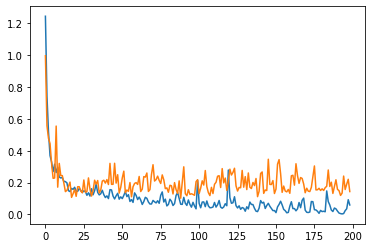

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list[1:])
plt.plot(val_loss_list[1:])

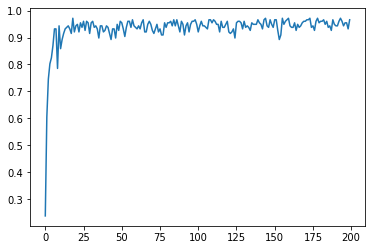

In [ ]:
plt.plot(ac_list)